In [414]:
%pylab inline
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'rm'

Populating the interactive namespace from numpy and matplotlib


In [415]:
import numpy as np
import pandas as pd
import h5py, itertools, scipy.stats
import matplotlib.pyplot as plt
import sys, os, re
from scipy.special import erf
from scipy.optimize import curve_fit
from andrew_tools.simple_tools import high_low_limit
import Claires_modules

def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

In [416]:
def cart2sph(x,y,z):
    import numpy as np
    XsqPlusYsq = np.square(x) + np.square(y)
    r = np.sqrt(XsqPlusYsq + np.square(z))         # r
    elev = np.arctan2(z,np.sqrt(XsqPlusYsq))       # phi
    az = np.arctan2(y,x)                           # theta
    return r, elev, az

def calc_open_angle(phi_x,the_x,phi_t,the_t):
    import numpy as np
    return np.arccos(np.cos(phi_t) * np.cos(phi_x) + np.sin(phi_t) * np.sin(phi_x) * np.cos(the_x - the_t))

def open_angle_mod(phi_x,the_x,phi_t,the_t):
    import numpy as np
    #calculate the two unit vectors and the two angles and then calculate the dot product
    
    return np.arccos(np.cos(phi_t) * np.cos(phi_x) + np.sin(phi_t) * np.sin(phi_x) * np.cos(the_x - the_t))

def calc_corr_factors(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, MW, Andr, pnts=1,M_t=8.0):
    import numpy as np
    # Rvir converted in Mpc (was kpc) 
    # In order to ignore this I think I just need to set this to zero
    #RO2 = Data_Rvir[Andr]/1000.
    
    DES_cone_len = 1.0 #Satellite[lstn][5]/1000.
    SDSS_cone_len = 1.0 #Satellite[lstn][4]/1000.  #t2 3

    DES_cone_size = 0.7259
    SDSS_coneS_size = 0.7259  #t2
    SDSS_coneB_size = 0.9929   #t3

    #corr_factors = np.zeros((len(data_files),pnts))
    #count_mas = np.zeros((len(data_files),pnts))

    radius_bins = np.linspace(0.0,0.1,101)

    h = 0.6751
    
    RO2 = 0.0
    
    # in Mpc
    z0_cens = np.vstack([Data_X,Data_Y,Data_Z]).T
    pair_dist = z0_cens[Andr] - z0_cens[MW]   # First two are the hosts (M31 & MW)
    coord_dist = z0_cens[2:] - z0_cens[MW]
    
    dis_g = np.linalg.norm(pair_dist)
    distances_from_center = np.linalg.norm(coord_dist,axis=1)[np.newaxis]
    
    angle_BG = np.arctan(RO2/dis_g)
    
    _, phi_x, the_x = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])
    _, phi_t, the_t = cart2sph(-pair_dist[0],-pair_dist[1],-pair_dist[2])

    ang_dis = calc_open_angle(phi_x,the_x,phi_t,the_t)

    Andr_gal = ang_dis <= angle_BG # Mask things that are in the same area as Andr.
    Andr_gal = Andr_gal[np.newaxis].T & np.ones(pnts,dtype = 'bool') # Make into N x pnts matrix

    #random
    #np.random.seed(777)
    u = np.random.uniform(0,1,pnts)
    v = np.random.uniform(0,1,pnts)

    the_t = 2. * np.pi * u
    phi_t = np.arccos(2. * v - 1)

    the_t2 = the_t - 0.09
    phi_t2 = phi_t + 1.18
    the_t3 = the_t + 3.1
    phi_t3 = phi_t + 1.72

    the_t2[ the_t2 < 0 ] += 2. * np.pi
    phi_t2[ phi_t2 > np.pi ] -= np.pi
    the_t3[ the_t3 > 2*np.pi ] -= 2*np.pi
    phi_t3[ phi_t3 > np.pi ] -= np.pi

    s = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])

    phi_x = (s[1])[np.newaxis].T
    the_x = (s[2])[np.newaxis].T
    r = s[0]

    dis = calc_open_angle(phi_x,the_x,phi_t,the_t)
    dis2 = calc_open_angle(phi_x,the_x,phi_t2,the_t2)
    dis3 = calc_open_angle(phi_x,the_x,phi_t3,the_t3)

    r_msk = (r[np.newaxis].T < np.ones(pnts)) & (~Andr_gal)

    r_SDSS = (r[np.newaxis].T < np.ones(pnts) * SDSS_cone_len) & r_msk
    s_SDSS = (dis2 <= SDSS_coneS_size) & r_SDSS
    b_SDSS = (dis3 <= SDSS_coneB_size) & r_SDSS
    
    in_SDSS = s_SDSS | b_SDSS
    in_DES = (r[np.newaxis].T < np.ones(pnts) * DES_cone_len) & (dis <= DES_cone_size) & r_msk

    in_cones = in_SDSS | in_DES
    
    #okay I believe if I just apply the below line mask to a matrix that is just the 
    #radii of each subhalo array stacked in a matrix 100 times.
    
    #for whatever reason the masked array doesn't really seem to work, and I really can't figure out why
    #so what I'm going to do is loop through each mask (weak) and then just go ahead and bin it up in a 
    #histogram since otherwise the different masks will lead to 
    
    stacked_distance_array_fast = np.broadcast_to(distances_from_center.T,(len(distances_from_center[0]),pnts))
    stacked_mass_array_fast = np.broadcast_to(Data_M[np.newaxis].T,(len(Data_M),pnts))
    
    #note: the below line "works" but it gives a 1d array of all the values that pass ANY of the masks (not useful)
    #all_dist_in_cones = stacked_distance_array_fast[in_cones]
    
    #This doesn't work for reasons that escape me, it doesn't mask ANY values
    #distances_within_cones = np.ma.MaskedArray(stacked_distance_array_fast, mask = in_cones)
    
    #The below works but it uses a loop
    
    histogram_matrix = np.zeros((pnts,len(radius_bins)-1))
    
    for ii in range(len(stacked_distance_array_fast[0])):
        #pull out each individual mask
        indiv_mask = in_cones[:,ii]
        #pull out each of the distance arrays (note: I could just use the distances as in always using the
        #distances_from_center array, but I matricized it in case I ever figure out how to do this without
        #a loop)
        indiv_dist = stacked_distance_array_fast[:,ii]
        #indiv_mass = 
        
        halos_within_cone = indiv_dist[indiv_mask]
        
        #now lets bin it with a histogram
        
        hist, bins = np.histogram(halos_within_cone,bins=radius_bins)
        histogram_matrix[ii] = np.cumsum(hist)
    
    #print len(masking_test)
    #print len(stacked_distance_array_fast[:,0][in_cones[:,0]])
    
    count_mas = np.sum(in_cones[Data_M[2:] >= M_t], axis = 0 ) * 1.
    count_tot = np.sum(r_msk[Data_M[2:] >= M_t], axis = 0 ) * 1.
    
    return histogram_matrix, radius_bins


def calc_corr_factors_mod(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, Data_Ids, MW, pnts=1,M_t=8.0):
    import numpy as np
    # Rvir converted in Mpc (was kpc) 
    # In order to ignore this I think I just need to set this to zero
    #RO2 = Data_Rvir[Andr]/1000.
    
    DES_cone_len = 1.0 #Satellite[lstn][5]/1000.
    SDSS_cone_len = 1.0 #Satellite[lstn][4]/1000.  #t2 3

    DES_cone_size = 0.7259
    SDSS_coneS_size = 0.7259  #t2
    SDSS_coneB_size = 0.9929   #t3

    #corr_factors = np.zeros((len(data_files),pnts))
    #count_mas = np.zeros((len(data_files),pnts))

    radius_bins = np.linspace(0.0,0.1,101)

    h = 0.6751
    
    RO2 = 0.0
    
    # in Mpc
    z0_cens = np.vstack([Data_X,Data_Y,Data_Z]).T
    print z0_cens, z0_cens[MW]
    coord_dist = z0_cens - z0_cens[MW]
    
    distances_from_center = np.linalg.norm(coord_dist,axis=1)[np.newaxis]
    
    _, phi_x, the_x = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])

    #random
    #np.random.seed(777)
    u = np.random.uniform(0,1,pnts)
    v = np.random.uniform(0,1,pnts)

    print u,v
    
    the_t = 2. * np.pi * u
    phi_t = np.arccos(2. * v - 1)

    #I believe this next bit fixes SDSS relative to the DES fields
    the_t2 = the_t - 0.09
    phi_t2 = phi_t + 1.18
    the_t3 = the_t + 3.1
    phi_t3 = phi_t + 1.72

    #I have no idea what this does
    the_t2[ the_t2 < 0 ] += 2. * np.pi
    phi_t2[ phi_t2 > np.pi ] -= np.pi
    the_t3[ the_t3 > 2*np.pi ] -= 2*np.pi
    phi_t3[ phi_t3 > np.pi ] -= np.pi

    s = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])

    #These are the phi, theta, and r in spherical coordinates
    phi_x = (s[1])[np.newaxis].T
    the_x = (s[2])[np.newaxis].T
    r = s[0]

    dis = calc_open_angle(phi_x,the_x,phi_t,the_t)
    dis2 = calc_open_angle(phi_x,the_x,phi_t2,the_t2)
    dis3 = calc_open_angle(phi_x,the_x,phi_t3,the_t3)

    r_msk = (r[np.newaxis].T < np.ones(pnts))

    r_SDSS = (r[np.newaxis].T < np.ones(pnts) * SDSS_cone_len) & r_msk
    s_SDSS = (dis2 <= SDSS_coneS_size) & r_SDSS
    b_SDSS = (dis3 <= SDSS_coneB_size) & r_SDSS
    
    in_SDSS = s_SDSS | b_SDSS
    in_DES = (r[np.newaxis].T < np.ones(pnts) * DES_cone_len) & (dis <= DES_cone_size) & r_msk

    in_cones = in_SDSS | in_DES

    #ids_in_SDSS = Data_Ids[np.newaxis].T[in_SDSS]
    #ids_in_DES = Data_Ids[np.newaxis].T[in_DES]
    #ids_in_both = Data_Ids[np.newaxis].T[in_cones]
    
    #okay I believe if I just apply the below line mask to a matrix that is just the 
    #radii of each subhalo array stacked in a matrix 100 times.
    
    #for whatever reason the masked array doesn't really seem to work, and I really can't figure out why
    #so what I'm going to do is loop through each mask (weak) and then just go ahead and bin it up in a 
    #histogram since otherwise the different masks will lead to 
    
    stacked_distance_array_fast = np.broadcast_to(distances_from_center.T,(len(distances_from_center[0]),pnts))
    stacked_mass_array_fast = np.broadcast_to(Data_M[np.newaxis].T,(len(Data_M),pnts))
    
    #note: the below line "works" but it gives a 1d array of all the values that pass ANY of the masks (not useful)
    #all_dist_in_cones = stacked_distance_array_fast[in_cones]
    
    #This doesn't work for reasons that escape me, it doesn't mask ANY values
    #distances_within_cones = np.ma.MaskedArray(stacked_distance_array_fast, mask = in_cones)
    
    #The below works but it uses a loop
    
    histogram_matrix = np.zeros((pnts,len(radius_bins)-1))
    
    #return histogram_matrix, radius_bins
    return in_SDSS, in_DES, in_cones

def Only_DES_cone(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, Data_Ids, MW, pnts=1,M_t=8.0):
    import numpy as np
    # Rvir converted in Mpc (was kpc) 
    # In order to ignore this I think I just need to set this to zero
    #RO2 = Data_Rvir[Andr]/1000.
    
    DES_cone_len = 1.0 #Satellite[lstn][5]/1000.

    DES_cone_size = 0.7259

    #corr_factors = np.zeros((len(data_files),pnts))
    #count_mas = np.zeros((len(data_files),pnts))

    radius_bins = np.linspace(0.0,0.1,101)

    h = 0.6751
    
    RO2 = 0.0
    
    # in Mpc
    z0_cens = np.vstack([Data_X,Data_Y,Data_Z]).T
    print z0_cens, z0_cens[MW]
    coord_dist = z0_cens - z0_cens[MW]
    
    distances_from_center = np.linalg.norm(coord_dist,axis=1)[np.newaxis]
    
    _, phi_x, the_x = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])

    #random
    #np.random.seed(777)
    u = np.random.uniform(0,1,pnts)
    v = np.random.uniform(0,1,pnts)

    print u,v
    
    the_t = 2. * np.pi * u
    phi_t = np.arccos(2. * v - 1)

    s = cart2sph(coord_dist[:,0],coord_dist[:,1],coord_dist[:,2])

    phi_x = (s[1])[np.newaxis].T
    the_x = (s[2])[np.newaxis].T
    r = s[0]

    dis = calc_open_angle(phi_x,the_x,phi_t,the_t)

    r_msk = (r[np.newaxis].T < np.ones(pnts))
    
    in_DES = (r[np.newaxis].T < np.ones(pnts) * DES_cone_len) & (dis <= DES_cone_size) & r_msk

    return in_DES

from random import gauss

def make_rand_vector(dims):
    import numpy as np
    vec = [gauss(0, 1) for i in range(dims)]
    mag = sum(x**2 for x in vec) ** .5
    return np.array([x/mag for x in vec])

def Only_DES_cartesian(Data_X, Data_Y, Data_Z, Data_M, Data_Rvir, Data_Ids, MW, pnts=1,M_t=8.0):
    import numpy as np
    # Rvir converted in Mpc (was kpc) 
    # In order to ignore this I think I just need to set this to zero
    #RO2 = Data_Rvir[Andr]/1000.
    
    DES_cone_len = 1.0 #Satellite[lstn][5]/1000.

    DES_cone_size = 0.69
    SDSS_coneS_size = 0.69  #t2
    SDSS_coneB_size = 0.9626   #t|
    #test values
    #DES_cone_size = np.pi/4.0
    #SDSS_coneS_size = np.pi/4.0  #t2
    #SDSS_coneB_size = np.pi/4.0   #t3
    
    #Define everything relative to DES vector
    des_direction = make_rand_vector(3)
    
    angles = cart2sph(*des_direction)
    the_t = angles[2]
    phi_t = angles[1]

    #I believe this next bit fixes SDSS relative to the DES fields
    the_t2 = the_t - 0.09
    phi_t2 = phi_t + 1.18
    the_t3 = the_t + 3.1
    phi_t3 = phi_t + 1.72
    
    #test vectors
    #des_direction = [1.0,0.0,0.0]
    #sdss_direction_one = [0.0,1.0,0.0]
    #sdss_direction_two = [0.0,0.0,1.0]
    sdss_direction_one = [np.cos(the_t2)*np.sin(phi_t2),np.sin(the_t2)*np.sin(phi_t2),np.cos(phi_t2)]
    sdss_direction_two = [np.cos(the_t3)*np.sin(phi_t3),np.sin(the_t3)*np.sin(phi_t3),np.cos(phi_t3)]
    
    h = 0.6751
    
    z0_cens = np.vstack([Data_X,Data_Y,Data_Z]).T
    coord_dist = z0_cens - z0_cens[MW]
    coord_norms = np.apply_along_axis(linalg.norm,1,coord_dist)
    
    coord_vectors = coord_dist / coord_norms.reshape((len(coord_norms),-1))
    
    #distances_from_center = np.linalg.norm(coord_dist,axis=1)[np.newaxis]

    dis = np.arccos(np.dot(coord_vectors,des_direction))
    dis2 = np.arccos(np.dot(coord_vectors,sdss_direction_one))
    dis3 = np.arccos(np.dot(coord_vectors,sdss_direction_two))    
    
    in_DES = (dis <= DES_cone_size)
    in_SDSS_one = (dis2 <= SDSS_coneS_size)
    in_SDSS_two = (dis3 <= SDSS_coneB_size)
    return in_DES, in_SDSS_one, in_SDSS_two, des_direction, sdss_direction_one, sdss_direction_two

0.8570582135979855
3982 401 1298 139
1838
1776


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:347: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:355: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:357: RuntimeWarning: invalid value encountered in less_equal


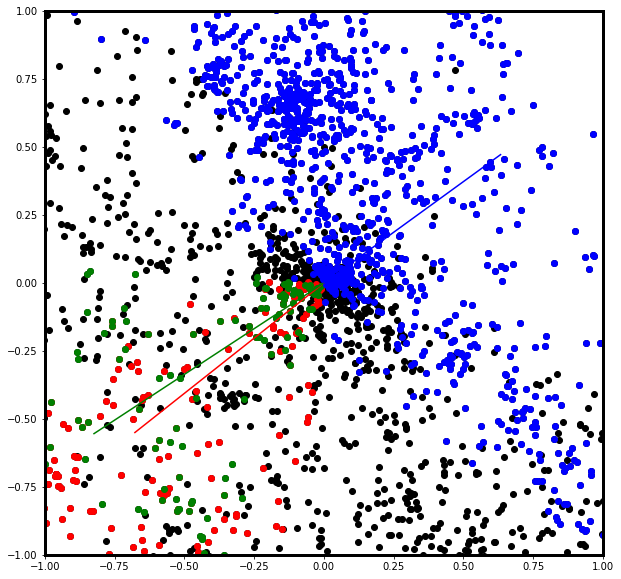

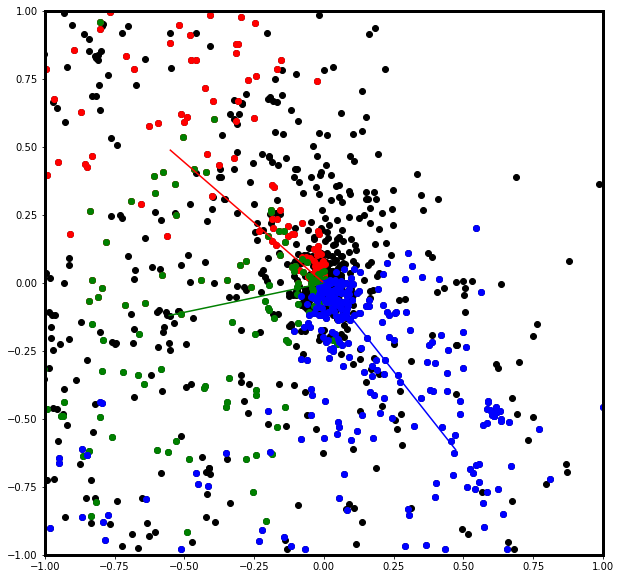

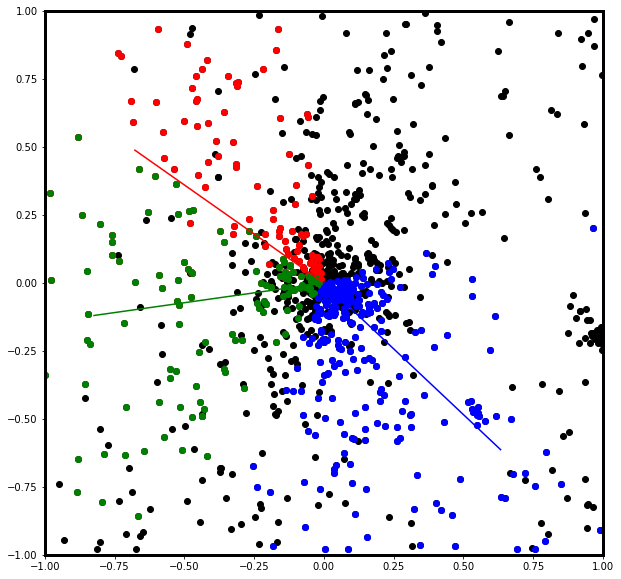

In [417]:
h = 0.6751

total_len = 0
total_hist = None

disk_total_len = 0
disk_total_hist = None

f_halos = h5py.File('../../initial_test_with_ELVIS/Tyler_Data/zoom_Z13_1107_cat.hdf5')
Data_Id = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['ID'][:]
Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]/h
Data_X = Data_cens[:,0]
Data_Y = Data_cens[:,1]
Data_Z = Data_cens[:,2]
Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h

M_t = 8.0

Vmax_mask = (Data_M>8.0)

Data_X_cut = Data_X[Vmax_mask]
Data_Y_cut = Data_Y[Vmax_mask]
Data_Z_cut = Data_Z[Vmax_mask]
Data_M_cut = Data_M[Vmax_mask]
Data_Mass_cut = Data_Mass[Vmax_mask]
Data_Rvir_cut = Data_Rvir[Vmax_mask]
Data_ID_cut = Data_Id[Vmax_mask]

host_index = np.argmax(Data_M_cut)
R_vir_host = Data_Rvir_cut[host_index]
host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
Data_X_norm = Data_X_cut-host_cen[0]
Data_Y_norm = Data_Y_cut-host_cen[1]
Data_Z_norm = Data_Z_cut-host_cen[2]

print Data_Mass_cut[host_index]/1.0e12

Andr = 0
MW = host_index

in_des, in_sdss_s, in_sdss_b, dir_des, dir_sdss_one, dir_sdss_two = Only_DES_cartesian(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut,Data_ID_cut, MW)

distances = np.sqrt((Data_X_cut-host_cen[0])**2.0+(Data_Y_cut-host_cen[1])**2.0+(Data_Z_cut-host_cen[2])**2.0)

print len(Data_X_cut), np.sum(in_des), np.sum(in_sdss_b), np.sum(in_sdss_s)
print np.sum(in_des)+np.sum(in_sdss_b)+np.sum(in_sdss_s)
print np.sum(in_des | in_sdss_b | in_sdss_s)

plt.figure(1,(10,10))
#plt.scatter(Data_X_cut,Data_Y_cut,color='k',s=1)
#plt.scatter(Data_X_norm[np.newaxis].T[in_sdss],Data_Y_norm[np.newaxis].T[in_sdss],color='b',s=1)
plt.scatter(Data_X_norm,Data_Y_norm,color='k',zorder=0)
plt.scatter(Data_X_norm[np.newaxis].T[in_des],Data_Y_norm[np.newaxis].T[in_des],color='r',zorder=1)
plt.scatter(Data_X_norm[np.newaxis].T[in_sdss_s],Data_Y_norm[np.newaxis].T[in_sdss_s],color='g',zorder=1)
plt.scatter(Data_X_norm[np.newaxis].T[in_sdss_b],Data_Y_norm[np.newaxis].T[in_sdss_b],color='b',zorder=1)

plt.plot([0.0,dir_des[0]],[0.0,dir_des[1]],color='r')
plt.plot([0.0,dir_sdss_one[0]],[0.0,dir_sdss_one[1]],color='g')
plt.plot([0.0,dir_sdss_two[0]],[0.0,dir_sdss_two[1]],color='b')
plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)
plt.show()

plt.figure(2,(10,10))
#plt.scatter(Data_X_cut,Data_Y_cut,color='k',s=1)
#plt.scatter(Data_Y_norm[np.newaxis].T[in_sdss],Data_Z_norm[np.newaxis].T[in_sdss],color='b',s=1)
plt.scatter(Data_Y_norm,Data_Z_norm,color='k')
plt.scatter(Data_Y_norm[np.newaxis].T[in_des],Data_Z_norm[np.newaxis].T[in_des],color='r',zorder=1)
plt.scatter(Data_Y_norm[np.newaxis].T[in_sdss_s],Data_Z_norm[np.newaxis].T[in_sdss_s],color='g',zorder=1)
plt.scatter(Data_Y_norm[np.newaxis].T[in_sdss_b],Data_Z_norm[np.newaxis].T[in_sdss_b],color='b',zorder=1)

plt.plot([0.0,dir_des[1]],[0.0,dir_des[2]],color='r')
plt.plot([0.0,dir_sdss_one[1]],[0.0,dir_sdss_one[2]],color='g')
plt.plot([0.0,dir_sdss_two[1]],[0.0,dir_sdss_two[2]],color='b')
plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)
plt.show()

plt.figure(1,(10,10))
#plt.scatter(Data_X_cut,Data_Y_cut,color='k',s=1)
#plt.scatter(Data_X_norm[np.newaxis].T[in_sdss],Data_Z_norm[np.newaxis].T[in_sdss],color='b',s=1)
plt.scatter(Data_X_norm,Data_Z_norm,color='k',zorder=0)
plt.scatter(Data_X_norm[np.newaxis].T[in_des],Data_Z_norm[np.newaxis].T[in_des],color='r',zorder=1)
plt.scatter(Data_X_norm[np.newaxis].T[in_sdss_s],Data_Z_norm[np.newaxis].T[in_sdss_s],color='g',zorder=1)
plt.scatter(Data_X_norm[np.newaxis].T[in_sdss_b],Data_Z_norm[np.newaxis].T[in_sdss_b],color='b',zorder=1)

plt.plot([0.0,dir_des[0]],[0.0,dir_des[2]],color='r')
plt.plot([0.0,dir_sdss_one[0]],[0.0,dir_sdss_one[2]],color='g')
plt.plot([0.0,dir_sdss_two[0]],[0.0,dir_sdss_two[2]],color='b')
plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)
plt.show()

0.495808
0.8570582135979855


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:347: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:355: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:357: RuntimeWarning: invalid value encountered in less_equal


(100, 99)
[ 1  1  1  1  1  1  2  2  2  2  2  2  2  2  3  4  6  7  9  9 10 10 12 13
 14 16 16 17 17 19 20 23 23 23 24 24 24 24 25 27 28 29 30 32 32 32 33 33
 37 40 41 44 44 47 48 48 50 51 52 53 53 54 55 59 59 60 63 63 64 65 68 69
 70 70 70 70 72 74 76 78 82 82 83 84 84 85 85 87 87 88 90 90 93 94 94 96
 97 97 99]


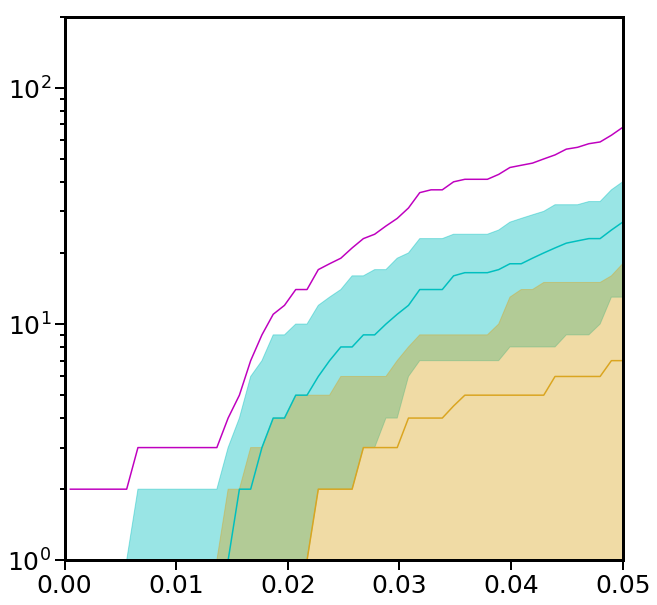

In [418]:
h = 0.6751

total_len = 0
total_hist = None

disk_total_len = 0
disk_total_hist = None

plt.figure(1,(10,10))

f_halos = h5py.File('../../initial_test_with_ELVIS/Tyler_Data/zoom_Z13_1107_cat.hdf5')
Data_Id = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['ID'][:]
Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]/h
Data_X = Data_cens[:,0]
Data_Y = Data_cens[:,1]
Data_Z = Data_cens[:,2]
Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h

print np.min(Data_M)

M_t = 8.0

Vmax_mask = (Data_M>8.0)

Data_X_cut = Data_X[Vmax_mask]
Data_Y_cut = Data_Y[Vmax_mask]
Data_Z_cut = Data_Z[Vmax_mask]
Data_M_cut = Data_M[Vmax_mask]
Data_Mass_cut = Data_Mass[Vmax_mask]
Data_Rvir_cut = Data_Rvir[Vmax_mask]
Data_ID_cut = Data_Id[Vmax_mask]

host_index = np.argmax(Data_M_cut)
R_vir_host = Data_Rvir_cut[host_index]
host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
Data_X_norm = Data_X_cut-host_cen[0]
Data_Y_norm = Data_Y_cut-host_cen[1]
Data_Z_norm = Data_Z_cut-host_cen[2]

print Data_Mass_cut[host_index]/1.0e12

Andr = 0
MW = host_index

numbins = 100
hist_total_all = np.zeros(numbins-1, dtype='int32')
hist_total_des = np.zeros(numbins-1, dtype='int32')
hist_total_both = np.zeros(numbins-1, dtype='int32')

#apparently its actually faster to do this as a loop
hist_total_all, hist_total_des, hist_total_both = [],[],[]

r_bins = np.linspace(0.0,0.1,numbins)
r_bins_plot = np.array([(r_bins[ii]+r_bins[ii+1])/2.0 for ii in range(len(r_bins)-1)])

for ii in range(100):
    in_des, in_sdss_s, in_sdss_b, dir_des, dir_sdss_one, dir_sdss_two = Only_DES_cartesian(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut,Data_ID_cut, MW)

    distances = np.sqrt((Data_X_cut-host_cen[0])**2.0+(Data_Y_cut-host_cen[1])**2.0+(Data_Z_cut-host_cen[2])**2.0)

    #print len(Data_X_cut), np.sum(in_des), np.sum(in_sdss_b), np.sum(in_sdss_s)
    #print np.sum(in_des)+np.sum(in_sdss_b)+np.sum(in_sdss_s)
    #print np.sum(in_des | in_sdss_b | in_sdss_s)

    in_all = in_des | in_sdss_b | in_sdss_s

    hist_tot, bins_tot = np.histogram(distances[(dist>0.0)],r_bins)
    hist_tot_c = np.cumsum(hist_tot)
    hist_total_all.append(hist_tot_c)
    #hist_total_all = np.vstack((hist_total_all,hist_tot_c))
    
    hist_des, bins_des = np.histogram(distances[np.newaxis].T[in_des&(dist>0.0)],r_bins)
    hist_des_c = np.cumsum(hist_des)
    hist_total_des.append(hist_des_c)
    #hist_total_des = np.vstack((hist_total_des,hist_des_c))
    
    hist_both, bins_both = np.histogram(distances[np.newaxis].T[in_all&(dist>0.0)],r_bins)
    hist_both_c = np.cumsum(hist_both)
    hist_total_both.append(hist_both_c)
    #hist_total_both = np.vstack((hist_total_both,hist_both_c))
    
hist_total_all = np.array(hist_total_all)
print hist_total_all.shape
hist_tot_med = np.median(hist_total_all,axis=0)
hist_tot_min = np.min(hist_total_all,axis=0)
hist_tot_max = np.max(hist_total_all,axis=0)

hist_total_des = np.array(hist_total_des)
hist_des_med = np.median(hist_total_des,axis=0)
hist_des_min = np.min(hist_total_des,axis=0)
hist_des_max = np.max(hist_total_des,axis=0)

hist_total_both = np.array(hist_total_both)
hist_both_med = np.median(hist_total_both,axis=0)
hist_both_min = np.min(hist_total_both,axis=0)
hist_both_max = np.max(hist_total_both,axis=0)

print hist_both_max

fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

plt.plot(r_bins_plot,hist_tot_med,color='m')

plt.plot(r_bins_plot,hist_both_med,color='c')
plt.fill_between(r_bins_plot,hist_both_min,hist_both_max,color='c',alpha=0.4)

plt.plot(r_bins_plot,hist_des_med,color='GoldenRod')
plt.fill_between(r_bins_plot,hist_des_min,hist_des_max,color='GoldenRod',alpha=0.4)

plt.yscale('log')

plt.xlim(0.0,0.05)
plt.ylim(1.0,200.0)
plt.yscale('log')
plt.show()

1.7859999999999998e-10


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:347: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:355: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:357: RuntimeWarning: invalid value encountered in less_equal


(100, 99)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  1  2  3  4  4  4  4  4  5  7  8  8  8 10 11 12 12 13 14 15 16 16 16 16
 17 18 18 18 18 20 21 21 22 23 26 26 26 28 28 28 28 29 30 30 30 30 30 32
 32 32 32 34 35 36 40 41 44 44 44 44 45 45 45 47 47 48 50 51 52 53 54 54
 55 58 58]


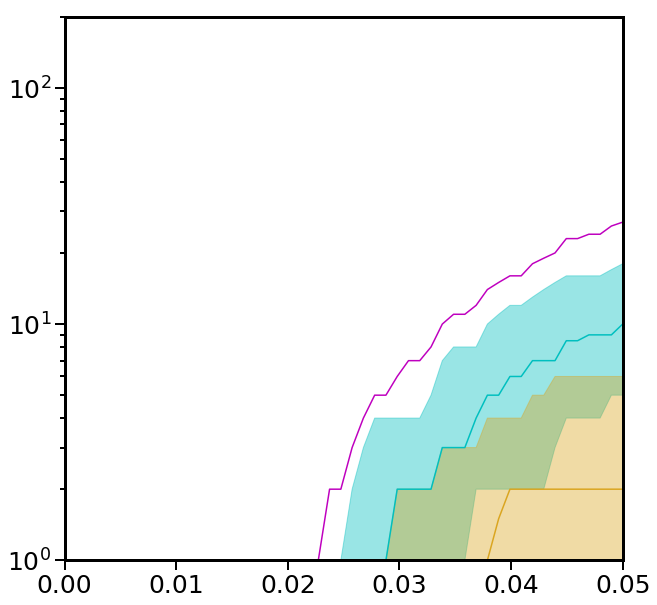

In [419]:
h = 0.6751

total_len = 0
total_hist = None

disk_total_len = 0
disk_total_hist = None

plt.figure(1,(10,10))

#f_halos = h5py.File('../../initial_test_with_ELVIS/Tyler_Data/zoom_Z13_1107_cat.hdf5')
#Data_Id = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['ID'][:]
#Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
#Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
#Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]/h
#Data_X = Data_cens[:,0]
#Data_Y = Data_cens[:,1]
#Data_Z = Data_cens[:,2]
#Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h

f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/reduced_data_1107_from_mt.txt')
Data_Vmax = f_halos[:,3]
Data_X = f_halos[:,0]/h
Data_Y = f_halos[:,1]/h
Data_Z = f_halos[:,2]/h
Data_Rvir = f_halos[:,5]/h
Data_M = f_halos[:,4]/h
Data_Vpeak = f_halos[:,6]

M_t = 8.0

Vmax_mask = (Data_Vmax>8.0)

Data_X_cut = Data_X[Vmax_mask]
Data_Y_cut = Data_Y[Vmax_mask]
Data_Z_cut = Data_Z[Vmax_mask]
Data_M_cut = Data_Vmax[Vmax_mask]
Data_Mass_cut = Data_Vmax[Vmax_mask]
Data_Rvir_cut = Data_Rvir[Vmax_mask]
#Data_ID_cut = Data_Id[Vmax_mask]

host_index = np.argmax(Data_M_cut)
R_vir_host = Data_Rvir_cut[host_index]
host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
Data_X_norm = Data_X_cut-host_cen[0]
Data_Y_norm = Data_Y_cut-host_cen[1]
Data_Z_norm = Data_Z_cut-host_cen[2]

print Data_Mass_cut[host_index]/1.0e12

Andr = 0
MW = host_index

numbins = 100
hist_total_all = np.zeros(numbins-1, dtype='int32')
hist_total_des = np.zeros(numbins-1, dtype='int32')
hist_total_both = np.zeros(numbins-1, dtype='int32')

#apparently its actually faster to do this as a loop
hist_total_all, hist_total_des, hist_total_both = [],[],[]

r_bins = np.linspace(0.0,0.1,numbins)
r_bins_plot = np.array([(r_bins[ii]+r_bins[ii+1])/2.0 for ii in range(len(r_bins)-1)])

for ii in range(100):
    in_des, in_sdss_s, in_sdss_b, dir_des, dir_sdss_one, dir_sdss_two = Only_DES_cartesian(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut,Data_ID_cut, MW)

    distances = np.sqrt((Data_X_cut-host_cen[0])**2.0+(Data_Y_cut-host_cen[1])**2.0+(Data_Z_cut-host_cen[2])**2.0)

    #print len(Data_X_cut), np.sum(in_des), np.sum(in_sdss_b), np.sum(in_sdss_s)
    #print np.sum(in_des)+np.sum(in_sdss_b)+np.sum(in_sdss_s)
    #print np.sum(in_des | in_sdss_b | in_sdss_s)

    in_all = in_des | in_sdss_b | in_sdss_s

    hist_tot, bins_tot = np.histogram(distances[(dist>0.0)],r_bins)
    hist_tot_c = np.cumsum(hist_tot)
    hist_total_all.append(hist_tot_c)
    #hist_total_all = np.vstack((hist_total_all,hist_tot_c))
    
    hist_des, bins_des = np.histogram(distances[np.newaxis].T[in_des&(dist>0.0)],r_bins)
    hist_des_c = np.cumsum(hist_des)
    hist_total_des.append(hist_des_c)
    #hist_total_des = np.vstack((hist_total_des,hist_des_c))
    
    hist_both, bins_both = np.histogram(distances[np.newaxis].T[in_all&(dist>0.0)],r_bins)
    hist_both_c = np.cumsum(hist_both)
    hist_total_both.append(hist_both_c)
    #hist_total_both = np.vstack((hist_total_both,hist_both_c))
    
hist_total_all = np.array(hist_total_all)
print hist_total_all.shape
hist_tot_med = np.median(hist_total_all,axis=0)
hist_tot_min = np.min(hist_total_all,axis=0)
hist_tot_max = np.max(hist_total_all,axis=0)

hist_total_des = np.array(hist_total_des)
hist_des_med = np.median(hist_total_des,axis=0)
hist_des_min = np.min(hist_total_des,axis=0)
hist_des_max = np.max(hist_total_des,axis=0)

hist_total_both = np.array(hist_total_both)
hist_both_med = np.median(hist_total_both,axis=0)
hist_both_min = np.min(hist_total_both,axis=0)
hist_both_max = np.max(hist_total_both,axis=0)

print hist_both_max

fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

plt.plot(r_bins_plot,hist_tot_med,color='m')

plt.plot(r_bins_plot,hist_both_med,color='c')
plt.fill_between(r_bins_plot,hist_both_min,hist_both_max,color='c',alpha=0.4)

plt.plot(r_bins_plot,hist_des_med,color='GoldenRod')
plt.fill_between(r_bins_plot,hist_des_min,hist_des_max,color='GoldenRod',alpha=0.4)

plt.yscale('log')

plt.xlim(0.0,0.05)
plt.ylim(1.0,200.0)
plt.yscale('log')
plt.show()

reduced_data_1107_from_mt.txt
1.7859999999999998e-10


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:347: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:355: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:357: RuntimeWarning: invalid value encountered in less_equal


reduced_data_1245_from_mt.txt
1.7293000000000002e-10
reduced_data_1386_from_mt.txt
1.6350999999999999e-10
reduced_data_493_from_mt.txt
2.0222999999999998e-10
reduced_data_539_from_mt.txt
2.0571e-10
reduced_data_609_from_mt.txt
1.9558e-10
reduced_data_694_from_mt.txt
1.8947e-10
reduced_data_795_from_mt.txt
1.8771000000000002e-10
reduced_data_833_from_mt.txt
1.6550999999999998e-10
reduced_data_848_from_mt.txt
2.0233000000000001e-10
reduced_data_879_from_mt.txt
1.8047999999999998e-10
reduced_data_988_from_mt.txt
1.7138e-10
(1200, 99)
[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  2
  2  4  4  5  5  6  6  6  6  7  7  7  8 10 11 12 12 13 14 15 16 16 19 20
 20 21 21 22 23 23 23 23 23 25 28 30 30 31 33 34 34 34 34 36 38 38 39 39
 40 41 42 43 45 47 48 48 48 48 48 51 52 52 52 54 56 56 57 58 58 58 59 59
 61 63 65]


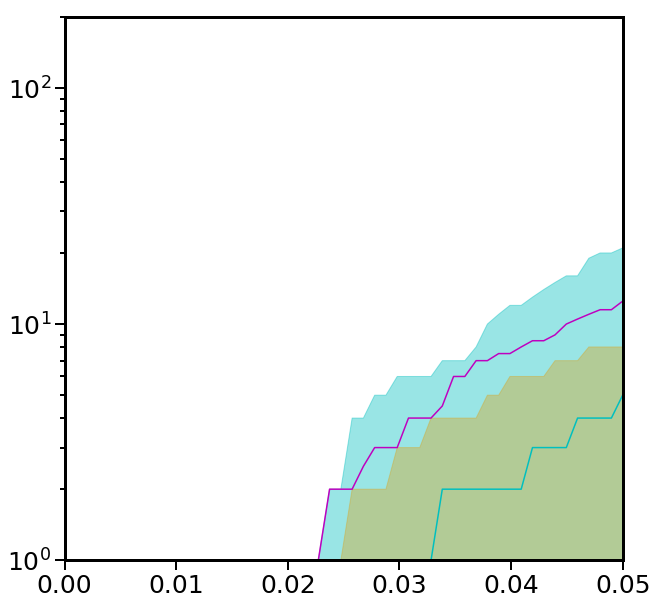

In [420]:
h = 0.6751

numbins = 100

#apparently its actually faster to do this as a loop
hist_total_all, hist_total_des, hist_total_both = [],[],[]

r_bins = np.linspace(0.0,0.1,numbins)
r_bins_plot = np.array([(r_bins[ii]+r_bins[ii+1])/2.0 for ii in range(len(r_bins)-1)])

for halo_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    print halo_file
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+halo_file)
    Data_Vmax = f_halos[:,3]
    Data_X = f_halos[:,0]/h
    Data_Y = f_halos[:,1]/h
    Data_Z = f_halos[:,2]/h
    Data_Rvir = f_halos[:,5]/h
    Data_M = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    M_t = 8.0

    Vmax_mask = (Data_Vmax>8.0)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_Vmax[Vmax_mask]
    Data_Mass_cut = Data_Vmax[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    #Data_ID_cut = Data_Id[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
    Data_X_norm = Data_X_cut-host_cen[0]
    Data_Y_norm = Data_Y_cut-host_cen[1]
    Data_Z_norm = Data_Z_cut-host_cen[2]

    print Data_Mass_cut[host_index]/1.0e12

    Andr = 0
    MW = host_index

    for ii in range(100):
        in_des, in_sdss_s, in_sdss_b, dir_des, dir_sdss_one, dir_sdss_two = Only_DES_cartesian(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut,Data_ID_cut, MW)

        distances = np.sqrt((Data_X_cut-host_cen[0])**2.0+(Data_Y_cut-host_cen[1])**2.0+(Data_Z_cut-host_cen[2])**2.0)

        #print len(Data_X_cut), np.sum(in_des), np.sum(in_sdss_b), np.sum(in_sdss_s)
        #print np.sum(in_des)+np.sum(in_sdss_b)+np.sum(in_sdss_s)
        #print np.sum(in_des | in_sdss_b | in_sdss_s)

        in_all = in_des | in_sdss_b | in_sdss_s

        hist_tot, bins_tot = np.histogram(distances[(dist>0.0)],r_bins)
        hist_tot_c = np.cumsum(hist_tot)
        hist_total_all.append(hist_tot_c)
        #hist_total_all = np.vstack((hist_total_all,hist_tot_c))

        hist_des, bins_des = np.histogram(distances[np.newaxis].T[in_des&(dist>0.0)],r_bins)
        hist_des_c = np.cumsum(hist_des)
        hist_total_des.append(hist_des_c)
        #hist_total_des = np.vstack((hist_total_des,hist_des_c))

        hist_both, bins_both = np.histogram(distances[np.newaxis].T[in_all&(dist>0.0)],r_bins)
        hist_both_c = np.cumsum(hist_both)
        hist_total_both.append(hist_both_c)
        #hist_total_both = np.vstack((hist_total_both,hist_both_c))

hist_total_all = np.array(hist_total_all)
print hist_total_all.shape
hist_tot_med = np.median(hist_total_all,axis=0)
hist_tot_min = np.min(hist_total_all,axis=0)
hist_tot_max = np.max(hist_total_all,axis=0)

hist_total_des = np.array(hist_total_des)
hist_des_med = np.median(hist_total_des,axis=0)
hist_des_min = np.min(hist_total_des,axis=0)
hist_des_max = np.max(hist_total_des,axis=0)

hist_total_both = np.array(hist_total_both)
hist_both_med = np.median(hist_total_both,axis=0)
hist_both_min = np.min(hist_total_both,axis=0)
hist_both_max = np.max(hist_total_both,axis=0)

print hist_both_max

fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

plt.plot(r_bins_plot,hist_tot_med,color='m')

plt.plot(r_bins_plot,hist_both_med,color='c')
plt.fill_between(r_bins_plot,hist_both_min,hist_both_max,color='c',alpha=0.4)

plt.plot(r_bins_plot,hist_des_med,color='GoldenRod')
plt.fill_between(r_bins_plot,hist_des_min,hist_des_max,color='GoldenRod',alpha=0.4)

plt.yscale('log')

plt.xlim(0.0,0.05)
plt.ylim(1.0,200.0)
plt.yscale('log')
plt.show()

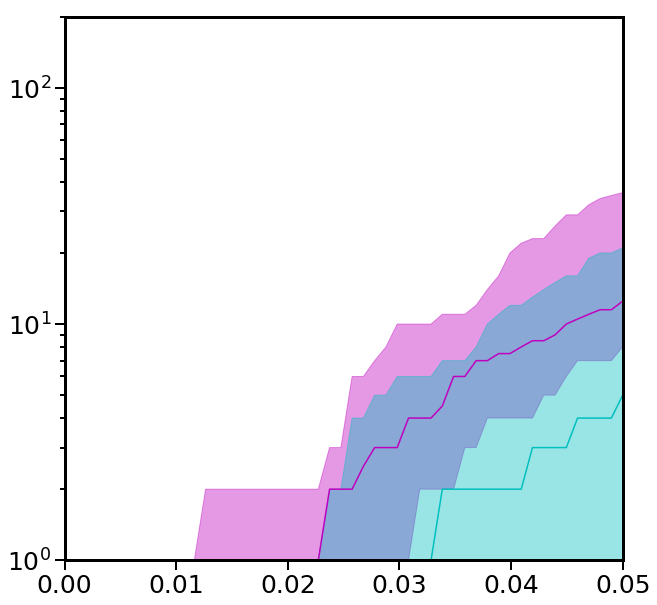

In [421]:
fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

plt.plot(r_bins_plot,hist_tot_med,color='m')
plt.fill_between(r_bins_plot,hist_tot_min,hist_tot_max,color='m',alpha=0.4)

plt.plot(r_bins_plot,hist_both_med,color='c')
plt.fill_between(r_bins_plot,hist_both_min,hist_both_max,color='c',alpha=0.4)

#plt.plot(r_bins_plot,hist_des_med,color='GoldenRod')
#plt.fill_between(r_bins_plot,hist_des_min,hist_des_max,color='GoldenRod',alpha=0.4)

plt.yscale('log')

plt.xlim(0.0,0.05)
plt.ylim(1.0,200.0)
plt.yscale('log')
plt.show()

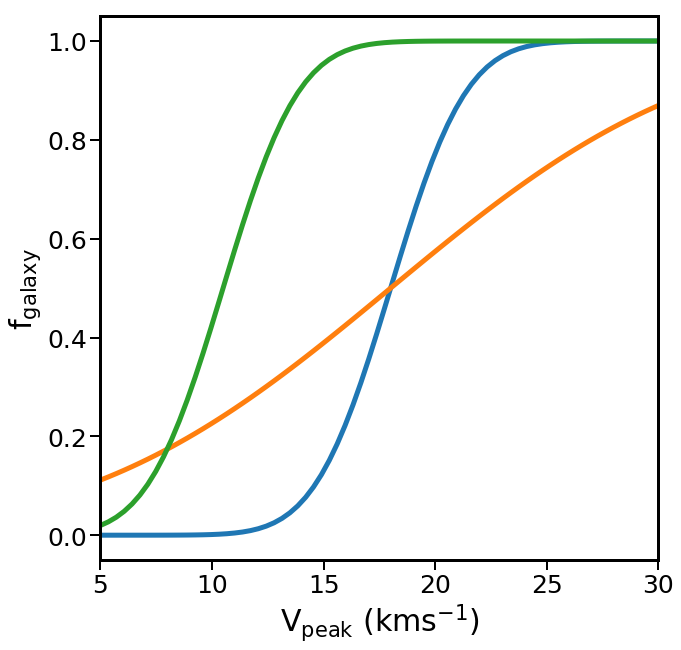

In [649]:
def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

v_max_fit = np.linspace(5.0,40.0,100)

popt = [2.66718967, 18.0]
popt_wide = [2.66718967*4.0, 18.0]
popt_low = [2.66718967, 20.98533531/2.0]
popt_bad = [14.5,0.0]

orig_fit = normal_cdf(v_max_fit,*popt)
wide_fit = normal_cdf(v_max_fit,*popt_wide)
low_fit = normal_cdf(v_max_fit,*popt_low)
bad_fit = normal_cdf(v_max_fit,*popt_bad)

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([5.0,30.0])
#plt.ylim([10.0,1000.0])
plt.xlabel('$V_{peak}$ $(km s^{-1})$',fontsize=30)
plt.ylabel('$f_{galaxy}$',fontsize=30)

plt.plot(v_max_fit,orig_fit,color='C0',linewidth=5)
plt.plot(v_max_fit,wide_fit,color='C1',linewidth=5)
plt.plot(v_max_fit,low_fit,color='C2',linewidth=5)
#plt.plot(v_max_fit,bad_fit,color='C3')

plt.legend(loc=1, prop={'size': 20})
#plt.xscale('log')
#plt.savefig('./low_line.png',bbox_inches='tight')
plt.show()

reduced_data_1107_from_mt.txt
reduced_data_1245_from_mt.txt
reduced_data_1386_from_mt.txt
reduced_data_493_from_mt.txt
reduced_data_539_from_mt.txt
reduced_data_609_from_mt.txt
reduced_data_694_from_mt.txt
reduced_data_795_from_mt.txt
reduced_data_833_from_mt.txt
reduced_data_848_from_mt.txt
reduced_data_879_from_mt.txt
reduced_data_988_from_mt.txt


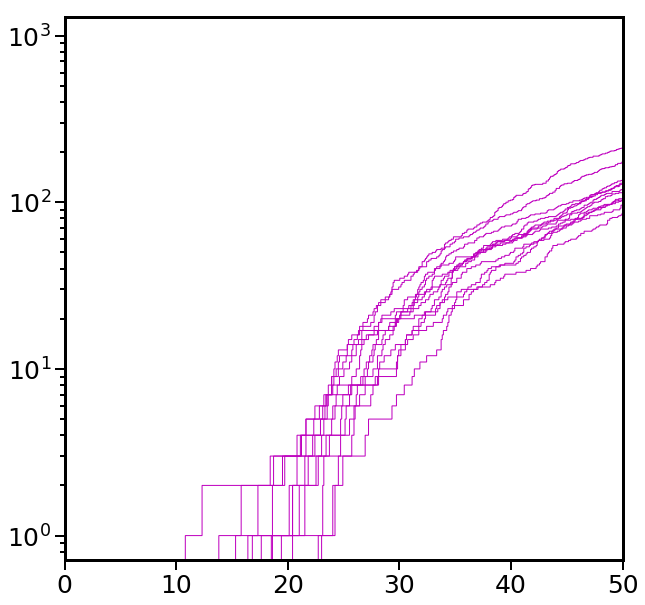

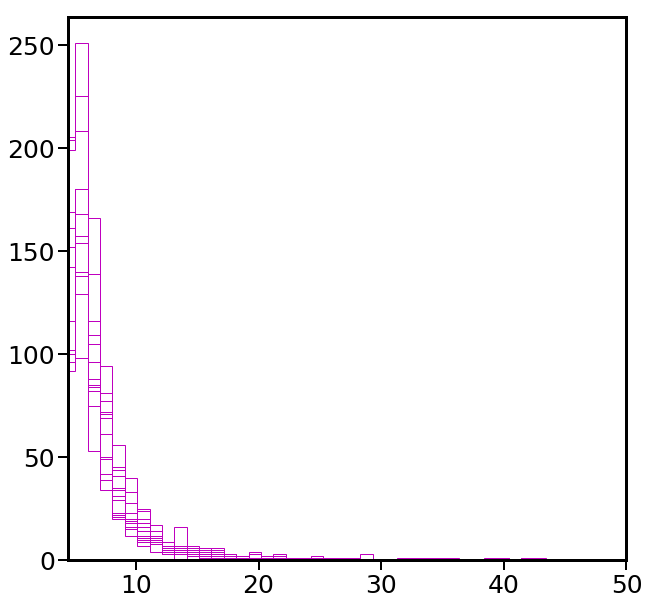

In [648]:
#I want to plot everything within 50 kpc of each disk sim
#and the vmax spectrum of these things

v_bins = np.linspace(0.0,100.0,100)

for halo_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    print halo_file
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+halo_file)
    Data_Vmax = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_M = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    M_t = 8.0

    Vmax_mask = (Data_Vmax>4.5)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_Vmax[Vmax_mask]
    Data_Mass_cut = Data_Vmax[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    #Data_ID_cut = Data_Id[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
    Data_X_norm = Data_X_cut-host_cen[0]
    Data_Y_norm = Data_Y_cut-host_cen[1]
    Data_Z_norm = Data_Z_cut-host_cen[2]
    
    distances = np.sqrt((Data_X_norm)**2.0+(Data_Y_norm)**2.0+(Data_Z_norm)**2.0)
    
    fig1 = plt.figure(1,(10,10))
    plt.hist(distances[(distances>0.0)],bins=r_bins,cumulative=True,histtype='step',color='m')
    
    fig2 = plt.figure(2,(10,10))
    plt.hist(Data_Vpeak_cut[(distances<100.0)&(distances>0.0)],bins=v_bins,histtype='step',color='m')
    
fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.yscale('log')


fig2 = plt.figure(2,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([4.5,50.0])
plt.show()  

In [659]:
h = 0.6751

numbins = 1000

#apparently its actually faster to do this as a loop
hist_total_all, hist_total_des, hist_total_both = [],[],[]
hist_total_fid, hist_total_wide, hist_total_low = [],[],[]

r_bins = np.linspace(0.0,100.0,numbins)
r_bins_plot = np.array([(r_bins[ii]+r_bins[ii+1])/2.0 for ii in range(len(r_bins)-1)])

for halo_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    print halo_file
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+halo_file)
    Data_Vmax = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_M = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    M_t = 8.0

    Vmax_mask = (Data_Vmax>4.5)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_Vmax[Vmax_mask]
    Data_Mass_cut = Data_Vmax[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    #Data_ID_cut = Data_Id[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
    Data_X_norm = Data_X_cut-host_cen[0]
    Data_Y_norm = Data_Y_cut-host_cen[1]
    Data_Z_norm = Data_Z_cut-host_cen[2]

    print Data_Mass_cut[host_index]/1.0e12

    Andr = 0
    MW = host_index

    for ii in range(100):
        in_des, in_sdss_s, in_sdss_b, dir_des, dir_sdss_one, dir_sdss_two = Only_DES_cartesian(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut,Data_ID_cut, MW)

        distances = np.sqrt((Data_X_cut-host_cen[0])**2.0+(Data_Y_cut-host_cen[1])**2.0+(Data_Z_cut-host_cen[2])**2.0)

        filled_frac = normal_cdf(Data_Vpeak_cut,*popt)
        filled_frac_wide = normal_cdf(Data_Vpeak_cut,*popt_wide)
        filled_frac_low = normal_cdf(Data_Vpeak_cut,*popt_low)
        
        weighted_coin_flip = np.array([True if random.random() < xx else False for xx in filled_frac])
        weighted_coin_flip_wide = np.array([True if random.random() < xx else False for xx in filled_frac_wide])
        weighted_coin_flip_low = np.array([True if random.random() < xx else False for xx in filled_frac_low])

        in_all = in_des | in_sdss_b | in_sdss_s

        hist_tot, bins_tot = np.histogram(distances[(distances>0.0)],r_bins)
        hist_tot_c = np.cumsum(hist_tot)
        hist_total_all.append(hist_tot_c)
        #hist_total_all = np.vstack((hist_total_all,hist_tot_c))

        hist_des, bins_des = np.histogram(distances[np.newaxis].T[in_des&(distances>0.0)],r_bins)
        hist_des_c = np.cumsum(hist_des)
        hist_total_des.append(hist_des_c)
        #hist_total_des = np.vstack((hist_total_des,hist_des_c))

        hist_both, bins_both = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)],r_bins)
        hist_both_c = np.cumsum(hist_both)
        hist_total_both.append(hist_both_c)
        #hist_total_both = np.vstack((hist_total_both,hist_both_c))
        
        hist_fid, bins_fid = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)&weighted_coin_flip],r_bins)
        hist_fid_c = np.cumsum(hist_fid)
        hist_total_fid.append(hist_fid_c)
        
        hist_wide, bins_wide = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)&weighted_coin_flip_wide],r_bins)
        hist_wide_c = np.cumsum(hist_wide)
        hist_total_wide.append(hist_wide_c)
        
        hist_low, bins_low = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)&weighted_coin_flip_low],r_bins)
        hist_low_c = np.cumsum(hist_low)
        hist_total_low.append(hist_low_c)
        

reduced_data_1107_from_mt.txt
1.7859999999999998e-10


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:347: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:355: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:357: RuntimeWarning: invalid value encountered in less_equal


reduced_data_1245_from_mt.txt
1.7293000000000002e-10
reduced_data_1386_from_mt.txt
1.6350999999999999e-10
reduced_data_493_from_mt.txt
2.0222999999999998e-10
reduced_data_539_from_mt.txt
2.0571e-10
reduced_data_609_from_mt.txt
1.9558e-10
reduced_data_694_from_mt.txt
1.8947e-10
reduced_data_795_from_mt.txt
1.8771000000000002e-10
reduced_data_833_from_mt.txt
1.6550999999999998e-10
reduced_data_848_from_mt.txt
2.0233000000000001e-10
reduced_data_879_from_mt.txt
1.8047999999999998e-10
reduced_data_988_from_mt.txt
1.7138e-10


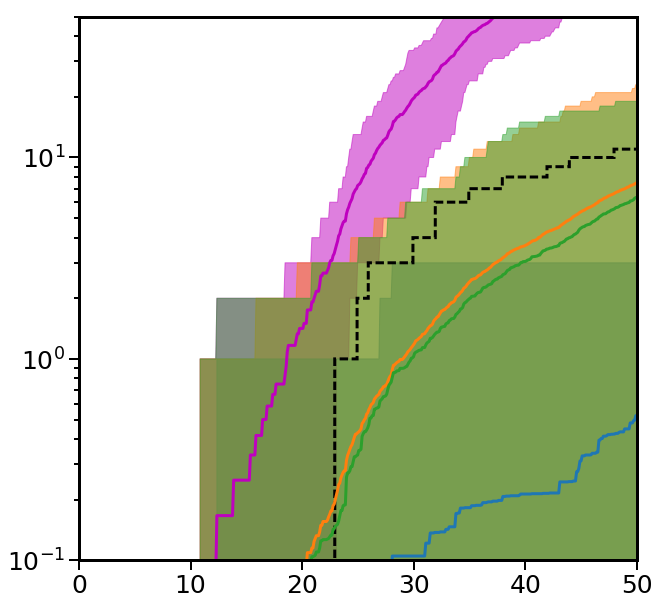

In [664]:
hist_total_all = np.array(hist_total_all)
hist_tot_mean = np.mean(hist_total_all,axis=0)
hist_tot_med = np.median(hist_total_all,axis=0)
hist_tot_min = np.min(hist_total_all,axis=0)
hist_tot_max = np.max(hist_total_all,axis=0)

hist_total_both = np.array(hist_total_both)
hist_both_med = np.median(hist_total_both,axis=0)
hist_both_mean = np.mean(hist_total_both,axis=0)
hist_both_min = np.min(hist_total_both,axis=0)
hist_both_max = np.max(hist_total_both,axis=0)

hist_total_fid = np.array(hist_total_fid)
hist_fid_med = np.median(hist_total_fid,axis=0)
hist_fid_mean = np.mean(hist_total_fid,axis=0)
hist_fid_low = np.percentile(hist_total_fid,84.1,axis=0)
hist_fid_high = np.percentile(hist_total_fid,15.9,axis=0)
hist_fid_min = np.min(hist_total_fid,axis=0)
hist_fid_max = np.max(hist_total_fid,axis=0)

hist_total_wide = np.array(hist_total_wide)
hist_wide_med = np.median(hist_total_wide,axis=0)
hist_wide_mean = np.mean(hist_total_wide,axis=0)
hist_wide_low = np.percentile(hist_total_wide,84.1,axis=0)
hist_wide_high = np.percentile(hist_total_wide,15.9,axis=0)
hist_wide_min = np.min(hist_total_wide,axis=0)
hist_wide_max = np.max(hist_total_wide,axis=0)

hist_total_low = np.array(hist_total_low)
hist_low_med = np.median(hist_total_low,axis=0)
hist_low_mean =  np.mean(hist_total_low,axis=0)
hist_low_low = np.percentile(hist_total_low,84.1,axis=0)
hist_low_high = np.percentile(hist_total_low,15.9,axis=0)
hist_low_min = np.min(hist_total_low,axis=0)
hist_low_max = np.max(hist_total_low,axis=0)

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]

fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

plt.plot(r_bins_plot,hist_tot_mean,color='m',linewidth=3)
plt.fill_between(r_bins_plot,hist_tot_min,hist_tot_max,color='m',alpha=0.5)

plt.plot(r_bins_plot,hist_fid_mean,color='C0',linewidth=3)
plt.fill_between(r_bins_plot,hist_fid_min,hist_fid_max,color='C0',alpha=0.5)

plt.plot(r_bins_plot,hist_wide_mean,color='C1',linewidth=3)
plt.fill_between(r_bins_plot,hist_wide_min,hist_wide_max,color='C1',alpha=0.5)

plt.plot(r_bins_plot,hist_low_mean,color='C2',linewidth=3)
plt.fill_between(r_bins_plot,hist_low_min,hist_low_max,color='C2',alpha=0.5)

data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_bins,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.yscale('log')

plt.xlim([0.0,50.0])
plt.ylim([0.1,50.0])
plt.yscale('log')
plt.show()

In [650]:
h = 0.6751

numbins = 1000

#apparently its actually faster to do this as a loop
hist_total_all, hist_total_des, hist_total_both = [],[],[]
hist_total_fid, hist_total_wide, hist_total_low = [],[],[]

r_bins = np.linspace(0.0,100.0,numbins)
r_bins_plot = np.array([(r_bins[ii]+r_bins[ii+1])/2.0 for ii in range(len(r_bins)-1)])


f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/reduced_data_493_from_mt.txt')
Data_Vmax = f_halos[:,3]
Data_X = f_halos[:,0]*1000.0/h
Data_Y = f_halos[:,1]*1000.0/h
Data_Z = f_halos[:,2]*1000.0/h
Data_Rvir = f_halos[:,5]/h
Data_M = f_halos[:,4]/h
Data_Vpeak = f_halos[:,6]

M_t = 8.0

Vmax_mask = (Data_Vmax>4.5)

Data_X_cut = Data_X[Vmax_mask]
Data_Y_cut = Data_Y[Vmax_mask]
Data_Z_cut = Data_Z[Vmax_mask]
Data_M_cut = Data_Vmax[Vmax_mask]
Data_Mass_cut = Data_Vmax[Vmax_mask]
Data_Rvir_cut = Data_Rvir[Vmax_mask]
Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
#Data_ID_cut = Data_Id[Vmax_mask]

host_index = np.argmax(Data_M_cut)
R_vir_host = Data_Rvir_cut[host_index]
host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
Data_X_norm = Data_X_cut-host_cen[0]
Data_Y_norm = Data_Y_cut-host_cen[1]
Data_Z_norm = Data_Z_cut-host_cen[2]

print Data_Mass_cut[host_index]/1.0e12

Andr = 0
MW = host_index

for ii in range(1000):
    in_des, in_sdss_s, in_sdss_b, dir_des, dir_sdss_one, dir_sdss_two = Only_DES_cartesian(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut,Data_ID_cut, MW)

    distances = np.sqrt((Data_X_cut-host_cen[0])**2.0+(Data_Y_cut-host_cen[1])**2.0+(Data_Z_cut-host_cen[2])**2.0)

    filled_frac = normal_cdf(Data_Vpeak_cut,*popt)
    filled_frac_wide = normal_cdf(Data_Vpeak_cut,*popt_wide)
    filled_frac_low = normal_cdf(Data_Vpeak_cut,*popt_low)

    weighted_coin_flip = np.array([True if random.random() < xx else False for xx in filled_frac])
    weighted_coin_flip_wide = np.array([True if random.random() < xx else False for xx in filled_frac_wide])
    weighted_coin_flip_low = np.array([True if random.random() < xx else False for xx in filled_frac_low])

    in_all = in_des | in_sdss_b | in_sdss_s

    hist_tot, bins_tot = np.histogram(distances[(distances>0.0)],r_bins)
    hist_tot_c = np.cumsum(hist_tot)
    hist_total_all.append(hist_tot_c)

    hist_des, bins_des = np.histogram(distances[np.newaxis].T[in_des&(distances>0.0)],r_bins)
    hist_des_c = np.cumsum(hist_des)
    hist_total_des.append(hist_des_c)

    hist_both, bins_both = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)],r_bins)
    hist_both_c = np.cumsum(hist_both)
    hist_total_both.append(hist_both_c)

    hist_fid, bins_fid = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)&weighted_coin_flip],r_bins)
    hist_fid_c = np.cumsum(hist_fid)
    hist_total_fid.append(hist_fid_c)

    hist_wide, bins_wide = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)&weighted_coin_flip_wide],r_bins)
    hist_wide_c = np.cumsum(hist_wide)
    hist_total_wide.append(hist_wide_c)

    hist_low, bins_low = np.histogram(distances[np.newaxis].T[in_all&(distances>0.0)&weighted_coin_flip_low],r_bins)
    hist_low_c = np.cumsum(hist_low)
    hist_total_low.append(hist_low_c)

2.0222999999999998e-10


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:347: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:355: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:357: RuntimeWarning: invalid value encountered in less_equal


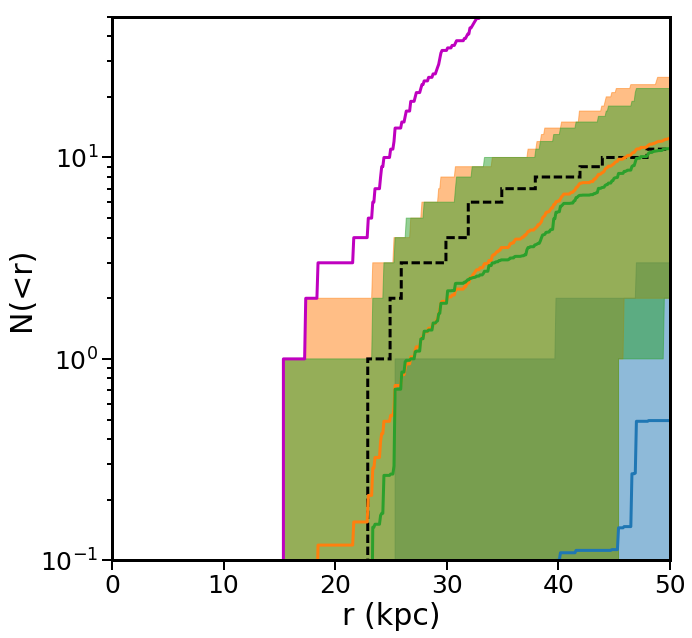

In [658]:
hist_total_all = np.array(hist_total_all)
hist_tot_mean = np.mean(hist_total_all,axis=0)
hist_tot_med = np.median(hist_total_all,axis=0)
hist_tot_min = np.min(hist_total_all,axis=0)
hist_tot_max = np.max(hist_total_all,axis=0)

hist_total_both = np.array(hist_total_both)
hist_both_med = np.median(hist_total_both,axis=0)
hist_both_mean = np.mean(hist_total_both,axis=0)
hist_both_min = np.min(hist_total_both,axis=0)
hist_both_max = np.max(hist_total_both,axis=0)

hist_total_fid = np.array(hist_total_fid)
hist_fid_med = np.median(hist_total_fid,axis=0)
hist_fid_mean = np.mean(hist_total_fid,axis=0)
hist_fid_low = np.percentile(hist_total_fid,84.1,axis=0)
hist_fid_high = np.percentile(hist_total_fid,15.9,axis=0)
hist_fid_min = np.min(hist_total_fid,axis=0)
hist_fid_max = np.max(hist_total_fid,axis=0)

hist_total_wide = np.array(hist_total_wide)
hist_wide_med = np.median(hist_total_wide,axis=0)
hist_wide_mean = np.mean(hist_total_wide,axis=0)
hist_wide_low = np.percentile(hist_total_wide,84.1,axis=0)
hist_wide_high = np.percentile(hist_total_wide,15.9,axis=0)
hist_wide_min = np.min(hist_total_wide,axis=0)
hist_wide_max = np.max(hist_total_wide,axis=0)

hist_total_low = np.array(hist_total_low)
hist_low_med = np.median(hist_total_low,axis=0)
hist_low_mean =  np.mean(hist_total_low,axis=0)
hist_low_low = np.percentile(hist_total_low,84.1,axis=0)
hist_low_high = np.percentile(hist_total_low,15.9,axis=0)
hist_low_min = np.min(hist_total_low,axis=0)
hist_low_max = np.max(hist_total_low,axis=0)

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]

#print hist_fid_mean, hist_fid_med

fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

plt.plot(r_bins_plot,hist_tot_mean,color='m',linewidth=3)
plt.fill_between(r_bins_plot,hist_tot_min,hist_tot_max,color='m',alpha=0.5)

plt.plot(r_bins_plot,hist_fid_mean,color='C0',linewidth=3)
plt.fill_between(r_bins_plot,hist_fid_min,hist_fid_max,color='C0',alpha=0.5)

plt.plot(r_bins_plot,hist_wide_mean,color='C1',linewidth=3)
plt.fill_between(r_bins_plot,hist_wide_min,hist_wide_max,color='C1',alpha=0.5)

plt.plot(r_bins_plot,hist_low_mean,color='C2',linewidth=3)
plt.fill_between(r_bins_plot,hist_low_min,hist_low_max,color='C2',alpha=0.5)

data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_bins,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.yscale('log')

plt.xlim([0.0,50.0])
plt.ylim([0.1,50.0])
plt.yscale('log')
plt.xlabel('r (kpc)',fontsize=30)
plt.ylabel('N(<r)',fontsize=30)
#plt.savefig('./low_model_high_mass.png')
plt.show()

[9.2, 3.4, 2.2, 2.7, 11.7, 4.9, 3.3, 6.9, 6.6, 3.4, 5.6, 6.7, 7.5, 3.7, 9.2, 7.9, 7.6, 4.0, 7.4, 2.3, 3.3, 2.7, 3.6, 4.6, 4.6, 7.6, 10.5, 4.6, 9.5, 8.4, 5.1, 9.1, 9.6, 5.4, 5.4, 8.6, 2.9, 5.4, 1.2]
[6628.553528075808, 905.3175659801078, 379.0429947529172, 570.9139321794972, 10720.494948703888, 1880.335186780484, 852.8467381940635, 3728.5613595426416, 3411.386952776254, 905.3175659801078, 2455.9479990602235, 3515.54546166497, 4405.200093977601, 1072.1278095387268, 6628.553528075808, 4887.61845093586, 4523.4552431670445, 1253.0346933980734, 4288.511238154907, 414.284595504738, 852.8467381940635, 570.9139321794972, 1014.9581016524395, 1657.138382018952, 1657.138382018952, 4523.4552431670445, 8634.192184196098, 1657.138382018952, 7067.898817448508, 5525.882997885503, 2036.9645234552424, 6485.237685018403, 7217.4798339729, 2283.655728717989, 2283.655728717989, 5792.152870232594, 658.6263607173622, 2283.655728717989, 112.77312240582657]


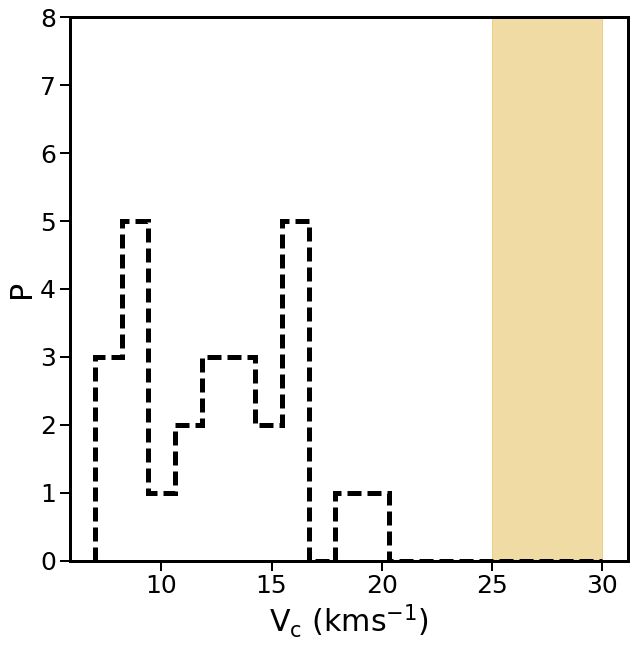

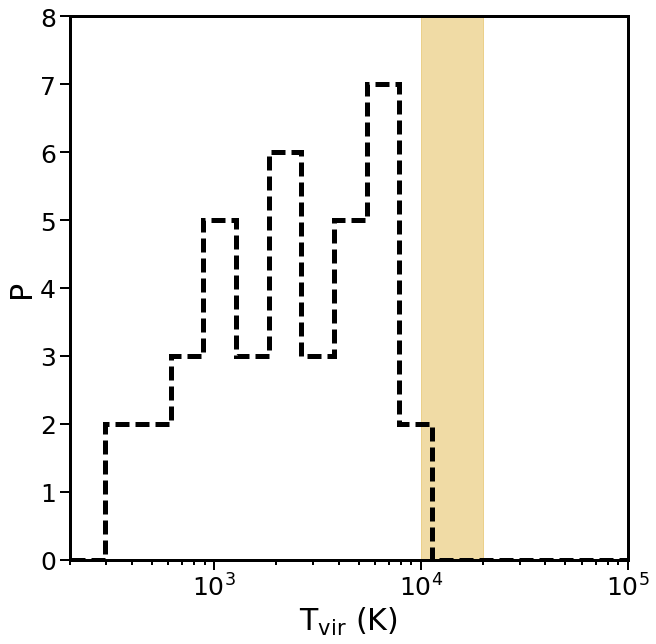

In [641]:
Vdisp = [9.1,9.5,11.4,9.,7.8,9.4,2.4,10.5,7.6,4.6,4.6,3.7,3.3,3.7,7.5,7.9,3.9,3.4,7.6,6.7,
         4.3,6.9,2.9,4.9,3.22,8.6,0.1,2.7,2.9,14.]

Vdisp = [6.6,9.1,11.7,9.2,6.6,9.5,9.2,7.9,11.4,9.,7.8,9.4,2.4,10.5,7.6,4.6,4.6,3.7,
         3.3,3.7,7.5,7.9,3.9,3.4,7.6,6.7,4.3,6.9,2.9,4.9,3.22,8.6,0.1,2.7,2.9,14.] #"complete"

Jsimon_data = np.loadtxt('/Users/andrewgraus/Downloads/mwdwarfs_sigma.dat',dtype=object)
Vdisp_js = [float(xx) for xx in Jsimon_data[:,1]]
Vdisp = [xx for xx in Vdisp_js if xx!=-9.9]

Vc = [np.sqrt(3.0*xx**2.0) for xx in Vdisp]
T_vir = [1.0e4*(xx/11.3)**2.0 for xx in Vdisp]

print Vdisp
print T_vir

v_bins = np.linspace(7.0,30.0,20)
T_bins = np.logspace(2.0,5.0,20)

fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

weights = np.ones_like(Vc)*(1.0/float(len(Vdisp)))

#plt.hist(Vc,bins=v_bins,weights=weights,color='k',linestyle='--',histtype='step',linewidth=5)
plt.hist(Vc,bins=v_bins,color='k',linestyle='--',histtype='step',linewidth=5)
plt.fill_betweenx([0.0,100.0],25.0,30.0,color='GoldenRod',alpha=0.4)

plt.xlabel('$V_{c}$ ($km s^{-1}$)',fontsize=30)
plt.ylabel('P',fontsize=30)
plt.ylim([0.0,8.0])
#plt.ylim([0.0,0.2])
plt.savefig('./V_c_real_all.png')
plt.show()

fig1 = plt.figure(2,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

#plt.hist(T_vir,bins=T_bins,weights=weights,color='k',linestyle='--',histtype='step',linewidth=5)
plt.hist(T_vir,bins=T_bins,color='k',linestyle='--',histtype='step',linewidth=5)
plt.fill_betweenx([0.0,100.0],1.0e4,2.0e4,color='GoldenRod',alpha=0.4)

plt.xlabel('$T_{vir}$ (K)',fontsize=30)
plt.ylabel('P',fontsize=30)
plt.xscale('log')
plt.ylim([0.0,8.0])
#plt.ylim([0.0,0.2])
plt.xlim([200.0,1.0e5])
plt.savefig('./T_vir_real_all.png')
plt.show()

reduced_data_1107_from_mt.txt
1.7859999999999998e-10
[178.6  127.17  97.38 ...   3.31   3.92   4.78]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:347: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:355: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:357: RuntimeWarning: invalid value encountered in less_equal


reduced_data_1245_from_mt.txt
1.7293000000000002e-10
[172.93  65.17  61.41 ...   5.61   3.01   5.09]
reduced_data_1386_from_mt.txt
1.6350999999999999e-10
[163.51  86.21  90.58 ...   4.23   3.83   4.51]
reduced_data_493_from_mt.txt
2.0222999999999998e-10
[202.23 112.49 104.24 ...   4.36   3.99   4.28]
reduced_data_539_from_mt.txt
2.0571e-10
[205.71  91.51  70.98 ...   4.51   3.27   4.38]
reduced_data_609_from_mt.txt
1.9558e-10
[195.58  87.08  94.63 ...   3.19   3.05   4.17]
reduced_data_694_from_mt.txt
1.8947e-10
[189.47 110.3   94.35 ...   3.74   3.16   3.22]
reduced_data_795_from_mt.txt
1.8771000000000002e-10
[187.71 104.41 104.37 ...   4.51   3.16   6.01]
reduced_data_833_from_mt.txt
1.6550999999999998e-10
[165.51 113.06  95.41 ...   3.87   4.48   5.28]
reduced_data_848_from_mt.txt
2.0233000000000001e-10
[201.95 107.27  81.27 ...   4.29   4.52   4.76]
reduced_data_879_from_mt.txt
1.8047999999999998e-10
[180.48 117.81  72.04 ...   5.24   4.31   3.65]
reduced_data_988_from_mt.txt
1.713

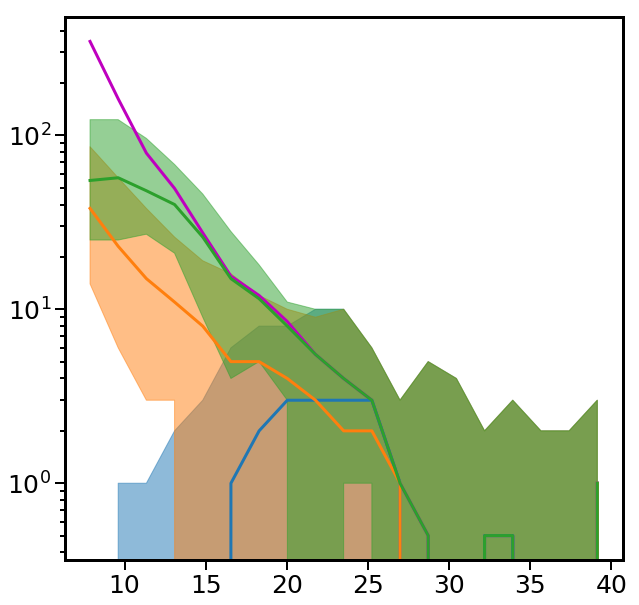

In [503]:
h = 0.6751

numbins = 1000

#apparently its actually faster to do this as a loop
hist_total_all, hist_total_des, hist_total_both = [],[],[]
hist_total_fid, hist_total_wide, hist_total_low = [],[],[]

v_bins = np.linspace(7.0,40.0,20)
v_bins_plot = np.array([(v_bins[ii]+v_bins[ii+1])/2.0 for ii in range(len(v_bins)-1)])

for halo_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    print halo_file
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+halo_file)
    Data_Vmax = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_M = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    M_t = 8.0

    Vmax_mask = (Data_Vmax>4.5)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_Vmax[Vmax_mask]
    Data_Mass_cut = Data_Vmax[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    #Data_ID_cut = Data_Id[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
    Data_X_norm = Data_X_cut-host_cen[0]
    Data_Y_norm = Data_Y_cut-host_cen[1]
    Data_Z_norm = Data_Z_cut-host_cen[2]

    print Data_Mass_cut[host_index]/1.0e12

    print Data_Vpeak_cut
    
    Andr = 0
    MW = host_index

    for ii in range(100):
        in_des, in_sdss_s, in_sdss_b, dir_des, dir_sdss_one, dir_sdss_two = Only_DES_cartesian(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut,Data_ID_cut, MW)

        distances = np.sqrt((Data_X_cut-host_cen[0])**2.0+(Data_Y_cut-host_cen[1])**2.0+(Data_Z_cut-host_cen[2])**2.0)

        #print distances
        
        filled_frac = normal_cdf(Data_Vpeak_cut,*popt)
        filled_frac_wide = normal_cdf(Data_Vpeak_cut,*popt_wide)
        filled_frac_low = normal_cdf(Data_Vpeak_cut,*popt_low)
        
        weighted_coin_flip = np.array([True if random.random() < xx else False for xx in filled_frac])
        weighted_coin_flip_wide = np.array([True if random.random() < xx else False for xx in filled_frac_wide])
        weighted_coin_flip_low = np.array([True if random.random() < xx else False for xx in filled_frac_low])

        in_all = in_des | in_sdss_b | in_sdss_s

        hist_tot, bins_tot = np.histogram(Data_Vpeak_cut[(distances>0.0)&(distances<300.0)],v_bins)
        hist_total_all.append(hist_tot)
        
        hist_des, bins_des = np.histogram(Data_Vpeak_cut[np.newaxis].T[(distances>0.0)&(distances<300.0)],v_bins)
        hist_total_des.append(hist_des)

        hist_both, bins_both = np.histogram(Data_Vpeak_cut[np.newaxis].T[(distances>0.0)&(distances<300.0)],v_bins)
        hist_total_both.append(hist_both)
        
        hist_fid, bins_fid = np.histogram(Data_Vpeak_cut[np.newaxis].T[(distances>0.0)&weighted_coin_flip&(distances<300.0)],v_bins)
        hist_total_fid.append(hist_fid)
        
        hist_wide, bins_wide = np.histogram(Data_Vpeak_cut[np.newaxis].T[(distances>0.0)&weighted_coin_flip_wide&(distances<300.0)],v_bins)
        hist_total_wide.append(hist_wide)
        
        hist_low, bins_low = np.histogram(Data_Vpeak_cut[np.newaxis].T[(distances>0.0)&weighted_coin_flip_low&(distances<300.0)],v_bins)
        hist_total_low.append(hist_low)
        
hist_total_all = np.array(hist_total_all)
hist_tot_mean = np.mean(hist_total_all,axis=0)
hist_tot_med = np.median(hist_total_all,axis=0)
hist_tot_min = np.min(hist_total_all,axis=0)
hist_tot_max = np.max(hist_total_all,axis=0)

hist_total_des = np.array(hist_total_des)
hist_des_med = np.median(hist_total_des,axis=0)
hist_des_mean = np.mean(hist_total_des,axis=0)
hist_des_min = np.min(hist_total_des,axis=0)
hist_des_max = np.max(hist_total_des,axis=0)

hist_total_both = np.array(hist_total_both)
hist_both_med = np.median(hist_total_both,axis=0)
hist_both_mean = np.mean(hist_total_both,axis=0)
hist_both_min = np.min(hist_total_both,axis=0)
hist_both_max = np.max(hist_total_both,axis=0)

hist_total_fid = np.array(hist_total_fid)
hist_fid_med = np.median(hist_total_fid,axis=0)
hist_fid_mean = np.mean(hist_total_fid,axis=0)
hist_fid_min = np.min(hist_total_fid,axis=0)
hist_fid_max = np.max(hist_total_fid,axis=0)

hist_total_wide = np.array(hist_total_wide)
hist_wide_med = np.median(hist_total_wide,axis=0)
hist_wide_mean = np.mean(hist_total_wide,axis=0)
hist_wide_min = np.min(hist_total_wide,axis=0)
hist_wide_max = np.max(hist_total_wide,axis=0)

hist_total_low = np.array(hist_total_low)
hist_low_med = np.median(hist_total_low,axis=0)
hist_low_mean = np.mean(hist_total_low,axis=0)
hist_low_min = np.min(hist_total_low,axis=0)
hist_low_max = np.max(hist_total_low,axis=0)

#f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
#gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
#gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

#large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

#large_gal_dist = gal_dist[large_gal_mask]

fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

plt.plot(v_bins_plot,hist_tot_med,color='m',linewidth=3)

plt.plot(v_bins_plot,hist_fid_med,color='C0',linewidth=3)
plt.fill_between(v_bins_plot,hist_fid_min,hist_fid_max,color='C0',alpha=0.5)

plt.plot(v_bins_plot,hist_wide_med,color='C1',linewidth=3)
plt.fill_between(v_bins_plot,hist_wide_min,hist_wide_max,color='C1',alpha=0.5)

plt.plot(v_bins_plot,hist_low_med,color='C2',linewidth=3)
plt.fill_between(v_bins_plot,hist_low_min,hist_low_max,color='C2',alpha=0.5)

#data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_bins,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

#plt.yscale('log')

#plt.xlim([0.0,50.0])
#plt.ylim([1.0,50.0])
plt.yscale('log')
plt.show()

[59.46       61.26333333 52.3925     40.14083333 26.1975     16.82916667
 12.13833333  7.74833333  5.33333333  4.25        3.          1.33333333
  1.16666667  0.66666667  0.75        0.75        0.58333333  0.5
  1.08333333]


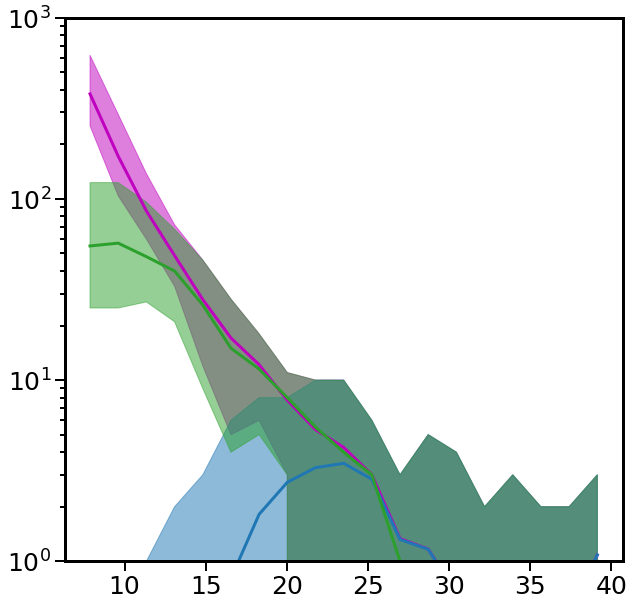

In [507]:
fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

print hist_low_mean

plt.plot(v_bins_plot,hist_tot_mean,color='m',linewidth=3)
#plt.plot(v_bins_plot,hist_tot_med,color='m',linewidth=3,linestyle='--')
plt.fill_between(v_bins_plot,hist_tot_min,hist_tot_max,color='m',alpha=0.5)

plt.plot(v_bins_plot,hist_fid_mean,color='C0',linewidth=3)
plt.fill_between(v_bins_plot,hist_fid_min,hist_fid_max,color='C0',alpha=0.5)

#plt.plot(v_bins_plot,hist_wide_med,color='C1',linewidth=3)
#plt.fill_between(v_bins_plot,hist_wide_min,hist_wide_max,color='C1',alpha=0.5)

plt.plot(v_bins_plot,hist_low_med,color='C2',linewidth=3)
plt.fill_between(v_bins_plot,hist_low_min,hist_low_max,color='C2',alpha=0.5)


#plt.hist(Vc,bins=v_bins,color='C0',histtype='step',linewidth=5)
#plt.fill_betweenx([0.0,1.0],25.0,30.0,color='GoldenRod',alpha=0.4)

#data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_bins,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

#plt.yscale('log')

#plt.xlim([0.0,50.0])
plt.ylim([1.0,1000.0])
plt.yscale('log')
plt.show()


In [609]:
h = 0.6751

numbins = 1000

#apparently its actually faster to do this as a loop
hist_total_all, hist_total_des, hist_total_both = [],[],[]
hist_total_fid, hist_total_wide, hist_total_low = [],[],[]

hist_total_all_vmax, hist_total_des_vmax, hist_total_both_vmax = [],[],[]
hist_total_fid_vmax, hist_total_wide_vmax, hist_total_low_vmax = [],[],[]

v_bins = np.linspace(0.0,40.0,30)
v_bins_plot = np.array([(v_bins[ii]+v_bins[ii+1])/2.0 for ii in range(len(v_bins)-1)])

for halo_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    print halo_file
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+halo_file)
    Data_Vmax = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_M = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    M_t = 8.0

    Vmax_mask = (Data_Vmax>4.5)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_Vmax[Vmax_mask]
    Data_Mass_cut = Data_Vmax[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]
    #Data_ID_cut = Data_Id[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = [Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]]
    Data_X_norm = Data_X_cut-host_cen[0]
    Data_Y_norm = Data_Y_cut-host_cen[1]
    Data_Z_norm = Data_Z_cut-host_cen[2]

    print Data_Mass_cut[host_index]/1.0e12

    print Data_Vpeak_cut
    
    Andr = 0
    MW = host_index

    for ii in range(100):
        in_des, in_sdss_s, in_sdss_b, dir_des, dir_sdss_one, dir_sdss_two = Only_DES_cartesian(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut,Data_ID_cut, MW)

        in_both = in_des | in_sdss_b | in_sdss_s
        
        distances = np.sqrt((Data_X_cut-host_cen[0])**2.0+(Data_Y_cut-host_cen[1])**2.0+(Data_Z_cut-host_cen[2])**2.0)

        #print distances
        
        filled_frac = normal_cdf(Data_Vpeak_cut,*popt)
        filled_frac_wide = normal_cdf(Data_Vpeak_cut,*popt_wide)
        filled_frac_low = normal_cdf(Data_Vpeak_cut,*popt_low)
        
        weighted_coin_flip = np.array([True if random.random() < xx else False for xx in filled_frac])
        weighted_coin_flip_wide = np.array([True if random.random() < xx else False for xx in filled_frac_wide])
        weighted_coin_flip_low = np.array([True if random.random() < xx else False for xx in filled_frac_low])

        in_all = in_des | in_sdss_b | in_sdss_s

        hist_tot, bins_tot = np.histogram(Data_Vpeak_cut[(distances>0.0)&(distances<50.0)],v_bins)
        if float(np.sum(hist_tot))==0.0:
            den_tot = 1.0
        else:
            den_tot = float(np.sum(hist_tot))
            
        hist_total_all.append(hist_tot/den_tot)
        hist_both, bins_both = np.histogram(Data_Vpeak_cut[np.newaxis].T[in_both&(distances>0.0)&(distances<50.0)],v_bins)
        if float(np.sum(hist_both))==0.0:
            den_both = 1.0
        else:
            den_both = float(np.sum(hist_both))
        hist_total_both.append(hist_both/den_both)
        
        hist_fid, bins_fid = np.histogram(Data_Vpeak_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip&(distances<50.0)],v_bins)
        if float(np.sum(hist_fid))==0.0:
            den_fid = 1.0
        else:
            den_fid = float(np.sum(hist_fid))
        hist_total_fid.append(hist_fid/den_fid)
        
        hist_wide, bins_wide = np.histogram(Data_Vpeak_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip_wide&(distances<50.0)],v_bins)
        if float(np.sum(hist_wide))==0.0:
            den_wide = 1.0
        else:
            den_wide = float(np.sum(hist_wide))
        hist_total_wide.append(hist_wide/den_wide)
        hist_low, bins_low = np.histogram(Data_Vpeak_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip_low&(distances<50.0)],v_bins)
        if float(np.sum(hist_low))==0.0:
            den_low = 1.0
        else:
            den_low = float(np.sum(hist_low))
        hist_total_low.append(hist_low/den_low)
        
        #Vmax
        hist_tot, bins_tot = np.histogram(Data_M_cut[(distances>0.0)&(distances<50.0)],v_bins)
        if float(np.sum(hist_tot))==0.0:
            den_tot = 1.0
        else:
            den_tot = float(np.sum(hist_tot))    
        hist_total_all_vmax.append(hist_tot/den_tot)
        hist_both, bins_both = np.histogram(Data_M_cut[np.newaxis].T[in_both&(distances>0.0)&(distances<50.0)],v_bins)
        if float(np.sum(hist_both))==0.0:
            den_both = 1.0
        else:
            den_both = float(np.sum(hist_both))
        hist_total_both_vmax.append(hist_both/den_both)
        
        hist_fid, bins_fid = np.histogram(Data_M_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip&(distances<50.0)],v_bins)
        if float(np.sum(hist_fid))==0.0:
            den_fid = 1.0
        else:
            den_fid = float(np.sum(hist_fid))
        hist_total_fid_vmax.append(hist_fid/den_fid)
        
        hist_wide, bins_wide = np.histogram(Data_M_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip_wide&(distances<50.0)],v_bins)
        if float(np.sum(hist_wide))==0.0:
            den_wide = 1.0
        else:
            den_wide = float(np.sum(hist_wide))
        hist_total_wide_vmax.append(hist_wide/den_wide)
        
        hist_low, bins_low = np.histogram(Data_M_cut[np.newaxis].T[in_both&(distances>0.0)&weighted_coin_flip_low&(distances<50.0)],v_bins)
        if float(np.sum(hist_low))==0.0:
            den_low = 1.0
        else:
            den_low = float(np.sum(hist_low))
        hist_total_low_vmax.append(hist_low/den_low)

reduced_data_1107_from_mt.txt
1.7859999999999998e-10
[178.6  127.17  97.38 ...   3.31   3.92   4.78]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:347: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:355: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:356: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:357: RuntimeWarning: invalid value encountered in less_equal


reduced_data_1245_from_mt.txt
1.7293000000000002e-10
[172.93  65.17  61.41 ...   5.61   3.01   5.09]
reduced_data_1386_from_mt.txt
1.6350999999999999e-10
[163.51  86.21  90.58 ...   4.23   3.83   4.51]
reduced_data_493_from_mt.txt
2.0222999999999998e-10
[202.23 112.49 104.24 ...   4.36   3.99   4.28]
reduced_data_539_from_mt.txt
2.0571e-10
[205.71  91.51  70.98 ...   4.51   3.27   4.38]
reduced_data_609_from_mt.txt
1.9558e-10
[195.58  87.08  94.63 ...   3.19   3.05   4.17]
reduced_data_694_from_mt.txt
1.8947e-10
[189.47 110.3   94.35 ...   3.74   3.16   3.22]
reduced_data_795_from_mt.txt
1.8771000000000002e-10
[187.71 104.41 104.37 ...   4.51   3.16   6.01]
reduced_data_833_from_mt.txt
1.6550999999999998e-10
[165.51 113.06  95.41 ...   3.87   4.48   5.28]
reduced_data_848_from_mt.txt
2.0233000000000001e-10
[201.95 107.27  81.27 ...   4.29   4.52   4.76]
reduced_data_879_from_mt.txt
1.8047999999999998e-10
[180.48 117.81  72.04 ...   5.24   4.31   3.65]
reduced_data_988_from_mt.txt
1.713

[19.7453792062852, 18.186533479473212, 7.967433714816835, 6.754998149518621, 5.888972745734183, 11.604740410711477, 7.447818472546172, 5.577203600371785, 5.0229473419497435, 24.24871130596428]


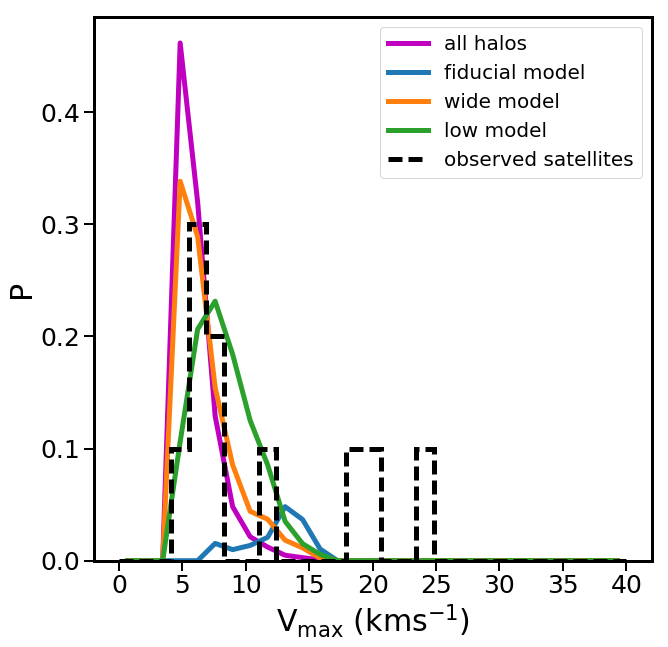

In [623]:
V_disp_in_50 = [11.4,10.5,4.6,3.9,3.4,6.7,4.3,3.22,2.9,14.0]
V_c_in_50 = [np.sqrt(3.0)*xx for xx in V_disp_in_50]
print V_c_in_50

hist_total_all = np.array(hist_total_all)
hist_tot_mean = np.mean(hist_total_all,axis=0)
hist_tot_med = np.median(hist_total_all,axis=0)
hist_tot_min = np.min(hist_total_all,axis=0)
hist_tot_max = np.max(hist_total_all,axis=0)

hist_total_both = np.array(hist_total_both)
hist_both_med = np.median(hist_total_both,axis=0)
hist_both_mean = np.mean(hist_total_both,axis=0)
hist_both_min = np.min(hist_total_both,axis=0)
hist_both_max = np.max(hist_total_both,axis=0)

hist_total_fid = np.array(hist_total_fid)
hist_fid_med = np.median(hist_total_fid,axis=0)
hist_fid_mean = np.mean(hist_total_fid,axis=0)
hist_fid_low = np.percentile(hist_total_fid,75,axis=0)
hist_fid_high = np.percentile(hist_total_fid,25,axis=0)
hist_fid_min = np.min(hist_total_fid,axis=0)
hist_fid_max = np.max(hist_total_fid,axis=0)

hist_total_wide = np.array(hist_total_wide)
hist_wide_med = np.median(hist_total_wide,axis=0)
hist_wide_mean = np.mean(hist_total_wide,axis=0)
hist_wide_low = np.percentile(hist_total_wide,75,axis=0)
hist_wide_high = np.percentile(hist_total_wide,25,axis=0)
hist_wide_min = np.min(hist_total_wide,axis=0)
hist_wide_max = np.max(hist_total_wide,axis=0)

hist_total_low = np.array(hist_total_low)
hist_low_med = np.median(hist_total_low,axis=0)
hist_low_mean =  np.mean(hist_total_low,axis=0)
hist_low_low = np.percentile(hist_total_low,75,axis=0)
hist_low_high = np.percentile(hist_total_low,25,axis=0)
hist_low_min = np.min(hist_total_low,axis=0)
hist_low_max = np.max(hist_total_low,axis=0)

#vmax
hist_total_all_vmax = np.array(hist_total_all_vmax)
hist_tot_mean_vmax = np.mean(hist_total_all_vmax,axis=0)
hist_tot_med_vmax = np.median(hist_total_all_vmax,axis=0)
hist_tot_min_vmax = np.min(hist_total_all_vmax,axis=0)
hist_tot_max_vmax = np.max(hist_total_all_vmax,axis=0)

hist_total_both_vmax = np.array(hist_total_both_vmax)
hist_both_med_vmax = np.median(hist_total_both_vmax,axis=0)
hist_both_mean_vmax = np.mean(hist_total_both_vmax,axis=0)
hist_both_min_vmax = np.min(hist_total_both_vmax,axis=0)
hist_both_max_vmax = np.max(hist_total_both_vmax,axis=0)

hist_total_fid_vmax = np.array(hist_total_fid_vmax)
hist_fid_med_vmax = np.median(hist_total_fid_vmax,axis=0)
hist_fid_mean_vmax = np.mean(hist_total_fid_vmax,axis=0)
hist_fid_low_vmax = np.percentile(hist_total_fid_vmax,75,axis=0)
hist_fid_high_vmax = np.percentile(hist_total_fid_vmax,25,axis=0)
hist_fid_min_vmax = np.min(hist_total_fid_vmax,axis=0)
hist_fid_max_vmax = np.max(hist_total_fid_vmax,axis=0)

hist_total_wide_vmax = np.array(hist_total_wide_vmax)
hist_wide_med_vmax = np.median(hist_total_wide_vmax,axis=0)
hist_wide_mean_vmax = np.mean(hist_total_wide_vmax,axis=0)
hist_wide_low_vmax = np.percentile(hist_total_wide_vmax,75,axis=0)
hist_wide_high_vmax = np.percentile(hist_total_wide_vmax,25,axis=0)
hist_wide_min_vmax = np.min(hist_total_wide_vmax,axis=0)
hist_wide_max_vmax = np.max(hist_total_wide_vmax,axis=0)

hist_total_low_vmax = np.array(hist_total_low_vmax)
hist_low_med_vmax = np.median(hist_total_low_vmax,axis=0)
hist_low_mean_vmax =  np.mean(hist_total_low_vmax,axis=0)
hist_low_low_vmax = np.percentile(hist_total_low_vmax,75,axis=0)
hist_low_high_vmax = np.percentile(hist_total_low_vmax,25,axis=0)
hist_low_min_vmax = np.min(hist_total_low_vmax,axis=0)
hist_low_max_vmax = np.max(hist_total_low_vmax,axis=0)


fig1 = plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)

#plt.plot(v_bins_plot,hist_tot_mean,color='m',linewidth=3,label='all halos')
plt.plot(v_bins_plot,hist_tot_mean_vmax,color='m',linewidth=5,label='all halos')
#plt.plot(v_bins_plot,hist_tot_med,color='m',linewidth=3,linestyle='--')
#plt.fill_between(v_bins_plot,hist_tot_min,hist_tot_max,color='m',alpha=0.5)

#plt.plot(v_bins_plot,hist_fid_mean,color='C0',linewidth=3,label='fiducial model')
plt.plot(v_bins_plot,hist_fid_mean_vmax,color='C0',linewidth=5,label='fiducial model')
#plt.fill_between(v_bins_plot,hist_fid_min,hist_fid_max,color='C0',alpha=0.5)
#plt.fill_between(v_bins_plot,hist_fid_low,hist_fid_high,color='C2',alpha=0.5)

#plt.plot(v_bins_plot,hist_wide_mean,color='C1',linewidth=3,label='wide model')
plt.plot(v_bins_plot,hist_wide_mean_vmax,color='C1',linewidth=5,label='wide model')
#plt.fill_between(v_bins_plot,hist_wide_min,hist_wide_max,color='C1',alpha=0.5)
#plt.fill_between(v_bins_plot,hist_wide_low,hist_wide_high,color='C2',alpha=0.5)

#plt.plot(v_bins_plot,hist_low_mean,color='C2',linewidth=3,label='low model')
plt.plot(v_bins_plot,hist_low_mean_vmax,color='C2',linewidth=5,label='low model')
#plt.fill_between(v_bins_plot,hist_low_min,hist_low_max,color='C2',alpha=0.5)
#plt.fill_between(v_bins_plot,hist_low_low,hist_low_high,color='C2',alpha=0.5)

V_c_weights = np.ones_like(V_c_in_50)*1.0/float(len(V_c_in_50))

plt.hist(V_c_in_50,bins=v_bins,weights=V_c_weights,color='k',linestyle='--',histtype='step',linewidth=5,zorder=5)
plt.plot([],[],color='k',linestyle='--',linewidth=5,label='observed satellites')

#plt.hist(Vc,bins=v_bins,color='C0',histtype='step',linewidth=5)
#plt.fill_betweenx([0.0,1.0],25.0,30.0,color='GoldenRod',alpha=0.4)

#data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_bins,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

#plt.yscale('log')

#plt.xlim([0.0,50.0])
#plt.ylim([1.0,5.0])
plt.ylabel('P',fontsize=30)
plt.xlabel('$V_{max}$ $(km s^{-1})$',fontsize=30)
#plt.yscale('log')
plt.savefig('./Vmax_sats.png')
plt.legend(fontsize=20)
plt.show()

In [580]:
print np.mean(hist_total_low,axis=0)
print np.max(hist_total_low,axis=0)
print np.min(hist_total_low,axis=0)


[0.137886   0.29061568 0.15645984 0.10881193 0.04658971 0.1338937
 0.05100529 0.07473785 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[0.4        0.5        0.5        0.3        0.14285714 0.28571429
 0.2        0.14285714 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [516]:
f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
name = f_dat[:,0]
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_dist<50.0)

large_gal_dist = gal_dist[large_gal_mask]
print name[large_gal_mask]
print gal_mass[large_gal_mask]


['Sagittarius I ' 'Bootes II' 'Coma' 'Segue I' 'Segue II' 'Ursa Major II'
 'Willman I' 'Cetus II' 'Reticulum II' 'Tucana III' 'Tucana IV']
[2.1e+07 1.0e+03 3.7e+03 3.4e+02 8.6e+02 4.1e+03 1.0e+03 1.0e+02 2.6e+03
 8.0e+02 2.2e+03]


In [705]:
a = np.array([[1.0,2.0,3.0],[2.0,5.0,10.0]])
b_index = np.max(a,axis=1)
print b_index[np.newaxis].T
b_mask = (a==b_index[np.newaxis].T)
print a[b_mask]

[[ 3.]
 [10.]]
[ 3. 10.]
